# Part 1 — Orientation Tracking (40 pts)

**Goal.** Estimate the body orientation over time using IMU angular velocity $\omega_t \in \mathbb{R}^3$ and linear acceleration $a_t \in \mathbb{R}^3$. We represent orientation with a unit quaternion $q_t \in \mathbb{H}^*$.

## Motion model (quaternion kinematics)
Given time step $\tau_t$ and gyro measurement $\omega_t$ (rad/s), predict:
$$
q_{t+1} = f(q_t, \tau_t \omega_t) := q_t \circ \exp\big([0,\; \tfrac{\tau_t \omega_t}{2}]\big).
$$

**Sanity check (IMU calibration).** Initialize $q_0 = [1,0,0,0]$ and integrate forward with the model above. Convert $q_t$ to roll/pitch/yaw and compare against VICON ground truth. The curves should align reasonably well. (You may use `transforms3d` for conversions.)

## Observation model (gravity)
Under pure rotation, gravity in the world frame is approximately $[0,0,-g]$ m/s$^2$ (or $[0,0,1]$ in gravity units). The predicted acceleration in the IMU frame is:
$$
[0, a_t] = h(q_t) := q_t^{-1} \circ [0,0,0,1] \circ q_t.
$$

## Optimization formulation
Estimate the trajectory $q_{1:T}$ by minimizing:
$$
\begin{aligned}
\mathcal{c}(q_{1:T}) &= \frac{1}{2}\sum_{t=0}^{T-1} \big\|2\,\log\big(q_{t+1}^{-1} \circ f(q_t, \tau_t \omega_t)\big)\big\|_2^2 \\
&\quad + \frac{1}{2}\sum_{t=1}^{T} \big\|[0,a_t] - h(q_t)\big\|_2^2,
\end{aligned}
$$
subject to the unit‑norm constraint $\|q_t\|_2 = 1$ for all $t$.

- The first term penalizes deviation from the motion model (via axis–angle error from the quaternion log).
- The second term enforces agreement with gravity.

## Projected gradient descent
Use projected gradient descent with the projection:
$$
\Pi_{\mathbb{H}^*}(q) = \frac{q}{\|q\|_2}.
$$
You may compute gradients with `torch.autograd.functional.jacobian` or derive them analytically.

## Deliverable
Plot estimated vs. VICON roll/pitch/yaw for the optimized trajectory $q_{1:T}$ (similar to Fig. 1 in the handout).

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import transforms3d as t3d
from load_data import read_data, tic, toc
import torch

# If you run into missing packages, install via:
# !pip install transforms3d scipy torch

# Prefer MPS on Apple Silicon, fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


## Quaternion helper functions

In [18]:
# ============================================================================
# QUATERNION HELPER FUNCTIONS (PyTorch versions for autograd)
# All quaternions are [w, x, y, z] (scalar first)
# ============================================================================

def quaternion_multiply(q1, q2):
    """Quaternion multiplication: q1 ⊙ q2
    q1, q2: quaternions as [w, x, y, z] (scalar first)
    Works with both numpy arrays and torch tensors
    """
    if isinstance(q1, torch.Tensor):
        w1, x1, y1, z1 = q1[0], q1[1], q1[2], q1[3]
        w2, x2, y2, z2 = q2[0], q2[1], q2[2], q2[3]
        return torch.stack([
            w1*w2 - x1*x2 - y1*y2 - z1*z2,
            w1*x2 + x1*w2 + y1*z2 - z1*y2,
            w1*y2 - x1*z2 + y1*w2 + z1*x2,
            w1*z2 + x1*y2 - y1*x2 + z1*w2
        ])
    else:
        w1, x1, y1, z1 = q1
        w2, x2, y2, z2 = q2
        w = w1*w2 - x1*x2 - y1*y2 - z1*z2
        x = w1*x2 + x1*w2 + y1*z2 - z1*y2
        y = w1*y2 - x1*z2 + y1*w2 + z1*x2
        z = w1*z2 + x1*y2 - y1*x2 + z1*w2
        return np.array([w, x, y, z])

def quaternion_conjugate(q):
    """Quaternion conjugate: q* = [w, -x, -y, -z]
    Works with both numpy arrays and torch tensors
    """
    if isinstance(q, torch.Tensor):
        return torch.stack([q[0], -q[1], -q[2], -q[3]])
    else:
        return np.array([q[0], -q[1], -q[2], -q[3]])

def quaternion_exponential(v):
    """Quaternion exponential for a pure quaternion [0, v].
    exp([0, v]) = [cos(||v||), sin(||v||) * v/||v||]
    v: 3D vector [x, y, z]
    Works with both numpy arrays and torch tensors
    """
    if isinstance(v, torch.Tensor):
        norm_v = torch.norm(v)
        if norm_v < 1e-10:
            return torch.tensor([1.0, 0.0, 0.0, 0.0], dtype=v.dtype, device=v.device)
        w = torch.cos(norm_v)
        xyz = torch.sin(norm_v) * v / norm_v
        return torch.cat([w.unsqueeze(0), xyz])
    else:
        norm_v = np.linalg.norm(v)
        if norm_v < 1e-10:
            return np.array([1.0, 0.0, 0.0, 0.0])
        w = np.cos(norm_v)
        xyz = np.sin(norm_v) * v / norm_v
        return np.array([w, xyz[0], xyz[1], xyz[2]])

def quaternion_log(q):
    """Quaternion log for unit quaternion. Returns 3D vector (axis * angle).
    Works with both numpy arrays and torch tensors
    """
    if isinstance(q, torch.Tensor):
        q = q / torch.norm(q)  # normalize
        w = torch.clamp(q[0], -1.0, 1.0)  # prevent numerical error
        v = q[1:]
        norm_v = torch.norm(v)
        if norm_v < 1e-12:
            return torch.zeros(3, dtype=q.dtype, device=q.device)
        angle = torch.atan2(norm_v, w)
        return angle * v / norm_v
    else:
        q = q / np.linalg.norm(q)  # normalize
        w = np.clip(q[0], -1.0, 1.0)
        v = q[1:]
        norm_v = np.linalg.norm(v)
        if norm_v < 1e-12:
            return np.zeros(3)
        angle = np.arctan2(norm_v, w)
        return angle * v / norm_v

def quaternion_to_euler(q):
    """Convert quaternion [w, x, y, z] to Euler angles (roll, pitch, yaw) in radians.
    Uses transforms3d (numpy only)
    """
    if isinstance(q, torch.Tensor):
        q = q.detach().cpu().numpy()
    # Convert to float64 for transforms3d compatibility with numpy 2.0
    q = np.asarray(q, dtype=np.float64)
    roll, pitch, yaw = t3d.euler.quat2euler(q)
    return roll, pitch, yaw

def euler_to_quaternion(roll, pitch, yaw):
    """Convert Euler angles (roll, pitch, yaw) to quaternion [w, x, y, z].
    Uses transforms3d (numpy only)
    """
    quat_wxyz = t3d.euler.euler2quat(roll, pitch, yaw)
    w, x, y, z = quat_wxyz
    return np.array([w, x, y, z])

def normalize_quaternion(q):
    """Normalize quaternion to unit length.
    Works with both numpy arrays and torch tensors
    """
    if isinstance(q, torch.Tensor):
        return q / torch.norm(q)
    else:
        return q / np.linalg.norm(q)

def gravity_in_imu(q):
    """Observation model: h(q) = q^{-1} ⊙ [0,0,0,1] ⊙ q
    Predicts gravity [0,0,1] in IMU frame (in g units)
    Works with both numpy arrays and torch tensors
    """
    if isinstance(q, torch.Tensor):
        g_quat = torch.tensor([0.0, 0.0, 0.0, 1.0], dtype=q.dtype, device=q.device)
    else:
        g_quat = np.array([0.0, 0.0, 0.0, 1.0])
    
    q_inv = quaternion_conjugate(q)
    result = quaternion_multiply(quaternion_multiply(q_inv, g_quat), q)
    return result[1:]  # return vector part only

# ============================================================================
# BATCH QUATERNION HELPER FUNCTIONS (for vectorized operations)
# All quaternions are (4, N) tensors where each column is [w, x, y, z]
# ============================================================================

def quaternion_multiply_batch(q1, q2):
    """Batch quaternion multiplication: q1 ⊙ q2
    q1, q2: (4, N) tensors where each column is [w, x, y, z]
    Returns: (4, N) tensor
    """
    w1, x1, y1, z1 = q1[0], q1[1], q1[2], q1[3]
    w2, x2, y2, z2 = q2[0], q2[1], q2[2], q2[3]
    return torch.stack([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def quaternion_conjugate_batch(q):
    """Batch quaternion conjugate: q* = [w, -x, -y, -z]
    q: (4, N) tensor
    Returns: (4, N) tensor
    """
    return torch.stack([q[0], -q[1], -q[2], -q[3]])

def quaternion_exponential_batch(v):
    """Batch quaternion exponential for pure quaternions [0, v].
    exp([0, v]) = [cos(||v||), sin(||v||) * v/||v||]
    v: (3, N) tensor where each column is a 3D vector
    Returns: (4, N) tensor
    """
    norm_v = torch.norm(v, dim=0, keepdim=True)  # (1, N)
    # Avoid division by zero
    norm_v = torch.clamp(norm_v, min=1e-10)
    
    w = torch.cos(norm_v)  # (1, N)
    xyz = torch.sin(norm_v) * v / norm_v  # (3, N)
    return torch.cat([w, xyz], dim=0)  # (4, N)

def quaternion_log_batch(q):
    """Batch quaternion log for unit quaternions. Returns 3D vectors (axis * angle).
    q: (4, N) tensor where each column is a unit quaternion
    Returns: (3, N) tensor
    """
    # Normalize
    q_norm = torch.norm(q, dim=0, keepdim=True)  # (1, N)
    q_norm = torch.clamp(q_norm, min=1e-10)
    q = q / q_norm
    
    w = q[0]  # (N,)
    v = q[1:]  # (3, N)
    
    w = torch.clamp(w, -1.0, 1.0)  # prevent numerical error
    norm_v = torch.norm(v, dim=0)  # (N,)
    
    # Compute angle: atan2(norm_v, w) for each column
    angle = torch.atan2(norm_v, w)  # (N,)
    
    # Avoid division by zero: where norm_v is tiny, set result to 0
    result = torch.where(
        norm_v.unsqueeze(0) < 1e-12,
        torch.zeros_like(v),
        angle.unsqueeze(0) * v / (norm_v.unsqueeze(0) + 1e-12)
    )
    return result  # (3, N)

def normalize_quaternion_batch(q):
    """Batch normalize quaternions to unit length.
    q: (4, N) tensor
    Returns: (4, N) tensor
    """
    norms = torch.norm(q, dim=0, keepdim=True)  # (1, N)
    return q / torch.clamp(norms, min=1e-10)

def gravity_in_imu_batch(q):
    """Batch observation model: h(q) = q^{-1} ⊙ [0,0,0,1] ⊙ q
    Predicts gravity [0,0,1] in IMU frame (in g units)
    q: (4, N) tensor where each column is [w, x, y, z]
    Returns: (3, N) tensor (vector part only)
    """
    device = q.device
    dtype = q.dtype
    N = q.shape[1]
    
    # Create [0,0,0,1] for all N quaternions
    g_quat = torch.zeros(4, N, dtype=dtype, device=device)
    g_quat[3, :] = 1.0  # Set z-component to 1
    
    # Compute q^{-1}
    q_inv = quaternion_conjugate_batch(q)
    
    # Compute q^{-1} ⊙ [0,0,0,1]
    temp = quaternion_multiply_batch(q_inv, g_quat)
    
    # Compute (q^{-1} ⊙ [0,0,0,1]) ⊙ q
    result = quaternion_multiply_batch(temp, q)
    
    return result[1:]  # return vector part only (3, N)

## Load data and Normalize

In [19]:
print("Loading data...")
ts = tic()

dataset = "1"  
cfile = "../data/trainset/cam/cam" + dataset + ".p"
ifile = "../data/trainset/imu/imuRaw" + dataset + ".p"
vfile = "../data/trainset/vicon/viconRot" + dataset + ".p"

camd = read_data(cfile)
imud = read_data(ifile)
vicd = read_data(vfile)

toc(ts, "Data import")

# Extract IMU data (imud is 7×N: [TimeStamps, Ax, Ay, Az, Wx, Wy, Wz])
imu_ts = imud[0, :]      # (N,): TimeStamps
imu_vals = imud[1:7, :]  # (6, N): [ax, ay, az, wx, wy, wz]

# ------------------------------
# IMU calibration (bias + scale)
# ------------------------------
VREF_MV = 3300.0
ACC_SENS_MV_PER_G = 330.0
GYRO_SENS_MV_PER_RAD = 3.33 * 180.0 / np.pi  # 4x gyro sensitivity per datasheet
ACC_SCALE = VREF_MV / 1023.0 / ACC_SENS_MV_PER_G     # g per count
GYRO_SCALE = VREF_MV / 1023.0 / GYRO_SENS_MV_PER_RAD  # rad/s per count

imu_time = imu_ts - imu_ts[0]
static_mask = imu_time < 2.0  # first 2 seconds assumed static

accel_raw = imu_vals[:3, :]
gyro_raw = imu_vals[3:, :]

# first average and then 
accel_bias = accel_raw[:, static_mask].mean(axis=1) - np.array([0.0, 0.0, 1.0]) / ACC_SCALE
gyro_bias = gyro_raw[:, static_mask].mean(axis=1) - np.array([0.0, 0.0, 0.0]) / GYRO_SCALE

accel = (accel_raw - accel_bias[:, None]) * ACC_SCALE  # in g
omega = (gyro_raw - gyro_bias[:, None]) * GYRO_SCALE   # rad/sec
print(f"shape of omega{omega.shape}")
# Extract VICON data (supports dict or tuple/list)
if isinstance(vicd, dict):
    vicon_rots = vicd["rots"]  # (3,3,N)
    vicon_ts = vicd["ts"]      # (1,N) or (N,)
else:
    raise ValueError(f"Unexpected VICON data format: {type(vicd)}")

vicon_ts = vicon_ts.flatten() if vicon_ts.ndim > 1 else vicon_ts

print(f"IMU data shape: {imu_vals.shape}, timestamps: {imu_ts.shape}")
print(f"VICON data shape: {vicon_rots.shape}, timestamps: {vicon_ts.shape}")

Loading data...
Data import took: 1.6135249137878418 sec.

shape of omega(3, 5645)
IMU data shape: (6, 5645), timestamps: (5645,)
VICON data shape: (3, 3, 5561), timestamps: (5561,)


In [20]:
# ============================================================================
# Verify calibration with static period data (first 2 seconds)
# ============================================================================

print("="*70)
print("CALIBRATION VERIFICATION - First 2 seconds (static period)")
print("="*70)

# Show time range
static_indices = np.where(static_mask)[0]
print(f"\nStatic period: {imu_time[static_indices[0]]:.3f}s to {imu_time[static_indices[-1]]:.3f}s")
print(f"Number of samples: {len(static_indices)}")

# Raw values during static period
print("\n" + "-"*70)
print("RAW VALUES (ADC counts) - First 5 samples:")
print("-"*70)
print("Time (s)     Ax_raw   Ay_raw   Az_raw   Wx_raw   Wy_raw   Wz_raw")
for i in range(min(5, len(static_indices))):
    idx = static_indices[i]
    print(f"{imu_time[idx]:7.3f}   {accel_raw[0,idx]:7.1f}  {accel_raw[1,idx]:7.1f}  {accel_raw[2,idx]:7.1f}  "
          f"{gyro_raw[0,idx]:7.1f}  {gyro_raw[1,idx]:7.1f}  {gyro_raw[2,idx]:7.1f}")

# Computed biases
print("\n" + "-"*70)
print("COMPUTED BIASES (ADC counts):")
print("-"*70)
print(f"Accel bias: [{accel_bias[0]:7.2f}, {accel_bias[1]:7.2f}, {accel_bias[2]:7.2f}]")
print(f"Gyro bias:  [{gyro_bias[0]:7.2f}, {gyro_bias[1]:7.2f}, {gyro_bias[2]:7.2f}]")

# Calibrated values during static period
print("\n" + "-"*70)
print("CALIBRATED VALUES - First 5 samples:")
print("-"*70)
print("Time (s)     Ax(g)    Ay(g)    Az(g)    Wx(r/s)  Wy(r/s)  Wz(r/s)")
for i in range(min(5, len(static_indices))):
    idx = static_indices[i]
    print(f"{imu_time[idx]:7.3f}   {accel[0,idx]:7.4f}  {accel[1,idx]:7.4f}  {accel[2,idx]:7.4f}  "
          f"{omega[0,idx]:7.4f}  {omega[1,idx]:7.4f}  {omega[2,idx]:7.4f}")

# Statistics over entire static period
print("\n" + "-"*70)
print("STATIC PERIOD STATISTICS (mean ± std):")
print("-"*70)
accel_static = accel[:, static_mask]
omega_static = omega[:, static_mask]

print(f"Accel X: {accel_static[0,:].mean():7.4f} ± {accel_static[0,:].std():7.4f} g  (expect ~0.0)")
print(f"Accel Y: {accel_static[1,:].mean():7.4f} ± {accel_static[1,:].std():7.4f} g  (expect ~0.0)")
print(f"Accel Z: {accel_static[2,:].mean():7.4f} ± {accel_static[2,:].std():7.4f} g  (expect ~1.0)")
print(f"Gyro  X: {omega_static[0,:].mean():7.4f} ± {omega_static[0,:].std():7.4f} rad/s  (expect ~0.0)")
print(f"Gyro  Y: {omega_static[1,:].mean():7.4f} ± {omega_static[1,:].std():7.4f} rad/s  (expect ~0.0)")
print(f"Gyro  Z: {omega_static[2,:].mean():7.4f} ± {omega_static[2,:].std():7.4f} rad/s  (expect ~0.0)")

print("\n" + "="*70)
print("✓ Calibration should show accel≈[0,0,1]g and gyro≈[0,0,0]rad/s")
print("="*70)

CALIBRATION VERIFICATION - First 2 seconds (static period)

Static period: 0.000s to 1.991s
Number of samples: 200

----------------------------------------------------------------------
RAW VALUES (ADC counts) - First 5 samples:
----------------------------------------------------------------------
Time (s)     Ax_raw   Ay_raw   Az_raw   Wx_raw   Wy_raw   Wz_raw
  0.000    -511.0   -501.0    605.0    374.0    376.0    370.0
  0.010    -511.0   -501.0    605.0    373.0    376.0    369.0
  0.020    -511.0   -501.0    606.0    374.0    375.0    370.0
  0.030    -511.0   -501.0    605.0    374.0    375.0    370.0
  0.040    -510.0   -501.0    605.0    374.0    374.0    370.0

----------------------------------------------------------------------
COMPUTED BIASES (ADC counts):
----------------------------------------------------------------------
Accel bias: [-510.79, -501.00,  502.85]
Gyro bias:  [ 373.60,  375.28,  369.70]

-----------------------------------------------------------------

## Quaternion integration (IMU ω → orientation)

In [21]:
print("Integrating angular velocity to estimate orientation...")
ts = tic()

N = imu_vals.shape[1]

# q0 = identity
q_est = np.zeros((4, N))
q_est[:, 0] = np.array([1.0, 0.0, 0.0, 0.0])# wxyz

# qt+1 = qt ⊙ exp([0, τt*ωt/2])
for i in range(N - 1):
    tau = imu_ts[i + 1] - imu_ts[i]
    omega_t = omega[:, i]
    exp_quat = quaternion_exponential(tau * omega_t / 2.0)
    q_est[:, i + 1] = quaternion_multiply(q_est[:, i], exp_quat)
    q_est[:, i + 1] = normalize_quaternion(q_est[:, i + 1])

toc(ts, "Quaternion integration")


Integrating angular velocity to estimate orientation...
Quaternion integration took: 0.06294417381286621 sec.



## Convert to Euler angles and prepare VICON ground truth

In [22]:
print("Converting quaternions to Euler angles...")
ts = tic()

euler_est = np.zeros((3, N))  # roll, pitch, yaw

for i in range(N):
    euler_est[:, i] = quaternion_to_euler(q_est[:, i])

toc(ts, "Euler angle conversion")

# VICON rotation matrices -> Euler
N_vicon = vicon_rots.shape[2]
euler_vicon = np.zeros((3, N_vicon))
for i in range(N_vicon):
    euler_vicon[:, i] = t3d.euler.mat2euler(vicon_rots[:, :, i])
    
# Relative time
imu_time = imu_ts - imu_ts[0]
vicon_time = vicon_ts - vicon_ts[0]


Converting quaternions to Euler angles...
Euler angle conversion took: 0.023082971572875977 sec.



## Plot roll / pitch / yaw (IMU integration vs VICON)

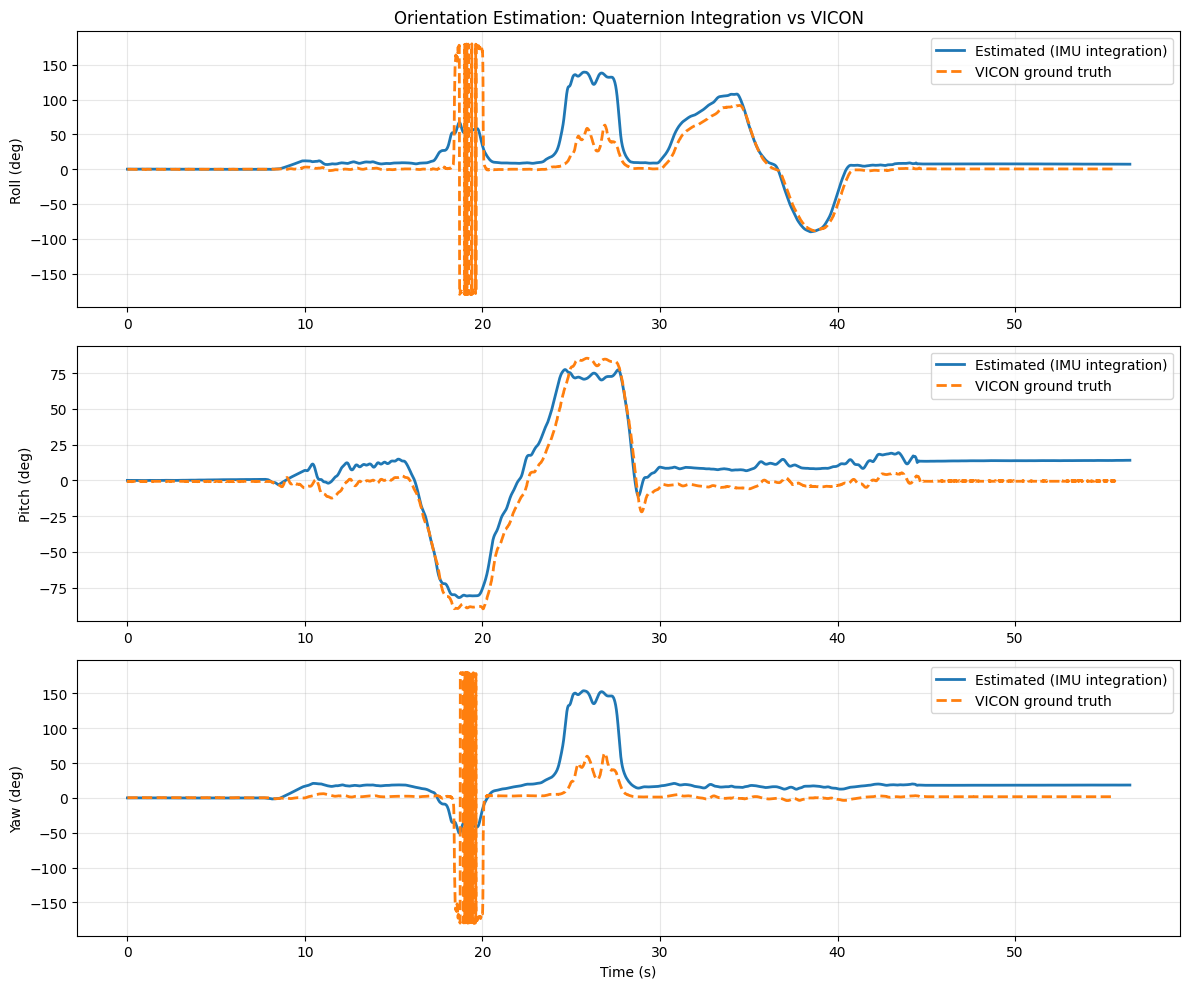

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(imu_time, np.degrees(euler_est[0, :]), label='Estimated (IMU integration)', linewidth=2)
axes[0].plot(vicon_time, np.degrees(euler_vicon[0, :]), '--', label='VICON ground truth', linewidth=2)
axes[0].set_ylabel('Roll (deg)')
axes[0].set_title('Orientation Estimation: Quaternion Integration vs VICON')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(imu_time, np.degrees(euler_est[1, :]), label='Estimated (IMU integration)', linewidth=2)
axes[1].plot(vicon_time, np.degrees(euler_vicon[1, :]), '--', label='VICON ground truth', linewidth=2)
axes[1].set_ylabel('Pitch (deg)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(imu_time, np.degrees(euler_est[2, :]), label='Estimated (IMU integration)', linewidth=2)
axes[2].plot(vicon_time, np.degrees(euler_vicon[2, :]), '--', label='VICON ground truth', linewidth=2)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Yaw (deg)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Error analysis (interpolate IMU estimate to VICON timestamps)

In [24]:
from scipy.interpolate import interp1d

# Interpolate IMU-estimated Euler angles to VICON timeline
f_roll = interp1d(imu_time, euler_est[0, :], kind='linear', fill_value='extrapolate')
f_pitch = interp1d(imu_time, euler_est[1, :], kind='linear', fill_value='extrapolate')
f_yaw = interp1d(imu_time, euler_est[2, :], kind='linear', fill_value='extrapolate')

euler_est_interp = np.array([
    f_roll(vicon_time),
    f_pitch(vicon_time),
    f_yaw(vicon_time)
])

# Errors (radians)
error_roll = euler_est_interp[0, :] - euler_vicon[0, :]
error_pitch = euler_est_interp[1, :] - euler_vicon[1, :]
error_yaw = euler_est_interp[2, :] - euler_vicon[2, :]

# Degrees
error_roll_deg = np.degrees(error_roll)
error_pitch_deg = np.degrees(error_pitch)
error_yaw_deg = np.degrees(error_yaw)

print("="*60)
print("ERROR ANALYSIS")
print("="*60)

print("\nRoll Error:")
print(f"  Mean: {np.mean(error_roll_deg):.4f}°")
print(f"  Std Dev: {np.std(error_roll_deg):.4f}°")
print(f"  Max: {np.max(np.abs(error_roll_deg)):.4f}°")

print("\nPitch Error:")
print(f"  Mean: {np.mean(error_pitch_deg):.4f}°")
print(f"  Std Dev: {np.std(error_pitch_deg):.4f}°")
print(f"  Max: {np.max(np.abs(error_pitch_deg)):.4f}°")

print("\nYaw Error:")
print(f"  Mean: {np.mean(error_yaw_deg):.4f}°")
print(f"  Std Dev: {np.std(error_yaw_deg):.4f}°")
print(f"  Max: {np.max(np.abs(error_yaw_deg)):.4f}°")

print("\n" + "="*60)
print("Rule of thumb: if errors are small (e.g., < 5°), IMU calibration is likely OK.")
print("="*60)


ERROR ANALYSIS

Roll Error:
  Mean: 13.9915°
  Std Dev: 37.3653°
  Max: 246.6668°

Pitch Error:
  Mean: 9.2158°
  Std Dev: 7.2824°
  Max: 23.2997°

Yaw Error:
  Mean: 19.3445°
  Std Dev: 33.7254°
  Max: 227.6342°

Rule of thumb: if errors are small (e.g., < 5°), IMU calibration is likely OK.


# Obervation model (gravity)

In [25]:
# Observation model: a_hat = h(q) = q^{-1} ⊙ [0,0,0,1] ⊙ q  (gravity in IMU frame, in g units)
ts = tic()
def gravity_in_imu(q):
    g_quat = np.array([0.0, 0.0, 0.0, 1.0])  # [0, 0, 0, 1] in gravity units
    q_inv = quaternion_conjugate(q)          # q^{-1} for unit quaternion
    return quaternion_multiply(quaternion_multiply(q_inv, g_quat), q)[1:]  # vector part

# Predict gravity for the current integrated orientation
a_pred = np.zeros((3, N))
for i in range(N):
    a_pred[:, i] = gravity_in_imu(q_est[:, i])

# Residual between measured accel (in g) and predicted gravity
accel_residual = accel - a_pred
toc(ts, "oberservation model multiplication")

# Sanity checks to verify observation model correctness
pred_norm = np.linalg.norm(a_pred, axis=0)
meas_norm = np.linalg.norm(accel, axis=0)
res_norm = np.linalg.norm(accel_residual, axis=0)
print("="*60)
print("OBSERVATION MODEL CHECKS")
print("="*60)
print(f"Predicted gravity norm: mean={pred_norm.mean():.4f}, std={pred_norm.std():.4f}")
print(f"Measured accel norm:    mean={meas_norm.mean():.4f}, std={meas_norm.std():.4f}")
print(f"Residual norm:         mean={res_norm.mean():.4f}, std={res_norm.std():.4f}")
print("(Expected: predicted/measurement norms near 1g; residuals small when motion is pure rotation.)")

oberservation model multiplication took: 0.027447223663330078 sec.

OBSERVATION MODEL CHECKS
Predicted gravity norm: mean=1.0000, std=0.0000
Measured accel norm:    mean=1.0050, std=0.0373
Residual norm:         mean=0.2236, std=0.1016
(Expected: predicted/measurement norms near 1g; residuals small when motion is pure rotation.)


# Constraint Optimization 

## Important Distinction: Initial Integration vs Optimization Cost

**Why do we compute `q_pred` instead of using `q_est[:, t+1]` directly?**

- **During initial integration (cell 9):** We built `q_est` by blindly following the gyroscope:
  - `q_est[:, t+1] = q_est[:, t] ⊙ exp(τ·ω/2)`
  - At this point, `q_est[:, t+1]` **equals** what the gyro predicts

- **During optimization (future cells):** We will refine `q_est` to balance TWO objectives:
  1. **Motion model:** Stay close to gyro predictions
  2. **Observation model:** Match gravity measurements
  
- **After optimization:** `q_est` values will have **changed** to fit both objectives
  - `q_pred = q_est[:, t] ⊙ exp(τ·ω/2)` = what gyro **still predicts** from current estimate
  - `q_est[:, t+1]` = optimized orientation (may deviate from pure gyro integration)
  - `q_err` = deviation between optimized trajectory and gyro prediction

The motion cost penalizes this deviation, preventing the optimizer from straying too far from the gyro measurements while trying to fit gravity.

In [26]:
# ============================================================================
# Cost function for optimization using PyTorch
# Uses the unified quaternion functions from cell 4
# ============================================================================

def compute_cost(q_traj, omega_data, accel_data, timestamps):
    """
    Compute total cost c(q_{1:T}) for the optimization problem.
    Using vectorized tensor operations instead of for loops.
    
    Args:
        q_traj: (4, N) torch tensor of quaternions [w,x,y,z] for all timesteps
        omega_data: (3, N) torch tensor of angular velocities (rad/s)
        accel_data: (3, N) torch tensor of accelerometer measurements (g)
        timestamps: (N,) torch tensor of timestamps
    
    Returns:
        total_cost: scalar torch tensor
    """
    N = q_traj.shape[1]
    device = q_traj.device
    dtype = q_traj.dtype
    
    # ========== Motion model cost term (vectorized) ==========
    # Compute all time intervals at once
    tau_all = timestamps[1:] - timestamps[:-1]  # (N-1,)
    
    # Compute all omega_t at once
    omega_t_all = omega_data[:, :-1]  # (3, N-1)
    
    # Compute all exp quaternions: exp([0, τ*ω/2])
    exp_input = (tau_all.unsqueeze(0) * omega_t_all / 2.0)  # (3, N-1)
    exp_quat_all = quaternion_exponential_batch(exp_input)  # (4, N-1)
    
    # Multiply q_t with exp_quat for all t
    q_t_all = q_traj[:, :-1]  # (4, N-1)
    q_pred_all = quaternion_multiply_batch(q_t_all, exp_quat_all)  # (4, N-1)
    q_pred_all = normalize_quaternion_batch(q_pred_all)
    
    # Error quaternions: q_err = q_{t+1}^{-1} ⊙ q_pred
    q_t1_all = q_traj[:, 1:]  # (4, N-1)
    q_t1_conj = quaternion_conjugate_batch(q_t1_all)
    q_err_all = quaternion_multiply_batch(q_t1_conj, q_pred_all)  # (4, N-1)
    q_err_all = normalize_quaternion_batch(q_err_all)
    
    # Hemisphere fix (avoid discontinuity)
    q_err_all = torch.where(q_err_all[0:1, :] < 0, -q_err_all, q_err_all)
    
    # Error vectors: e = 2 * log(q_err)
    e_all = 2.0 * quaternion_log_batch(q_err_all)  # (3, N-1)
    
    # Motion cost: sum of 0.5 * ||e||^2 for each timestep
    motion_cost = 0.5 * torch.sum(torch.sum(e_all ** 2, dim=0))
    
    # ========== Observation model cost term (vectorized) ==========
    # Predicted gravity in IMU frame for all quaternions
    a_pred_all = gravity_in_imu_batch(q_traj)  # (3, N)
    residual_all = accel_data - a_pred_all  # (3, N)
    
    # Observation cost: sum of 0.5 * ||residual||^2 for each timestep
    obs_cost = 0.5 * torch.sum(torch.sum(residual_all ** 2, dim=0))
    
    # Weighted combination
    return 1.9 * motion_cost + 0.1 * obs_cost

# Convert numpy data to PyTorch tensors
omega_torch = torch.from_numpy(omega).float().to(device)
accel_torch = torch.from_numpy(accel).float().to(device)
imu_ts_torch = torch.from_numpy(imu_ts).float().to(device)
q_est_torch = torch.from_numpy(q_est).float().to(device)

# Test the cost function with initial integration
initial_cost = compute_cost(q_est_torch, omega_torch, accel_torch, imu_ts_torch)
print("="*60)
print("INITIAL COST (before optimization)")
print("="*60)
print(f"Total cost: {initial_cost.item():.6f}")

INITIAL COST (before optimization)
Total cost: 17.173277


## Projected Gradient Descent Optimization

In [27]:
def project_to_unit_quaternions(q_traj):
    """
    Project each quaternion to unit norm: Π(q) = q / ||q||
    
    Args:
        q_traj: (4, N) tensor of quaternions
    
    Returns:
        projected q_traj with unit norm for each column
    """
    norms = torch.norm(q_traj, dim=0, keepdim=True)  # (1, N)
    return q_traj / norms

def optimize_trajectory(
    q_init, omega_data, accel_data, timestamps,
    learning_rate=0.005, num_iterations=50, verbose=True,
    lr_decay=0.5, lr_patience=7, min_lr=1e-4,
    adaptive_lr=True,
):
    """
    Optimize quaternion trajectory using projected gradient descent (PGD)
    but using a PyTorch optimizer (Adam/SGD) for the descent step.
    
    Projection: normalize each quaternion back to unit norm after each step.
    
    Args:
        adaptive_lr: If True, decay LR when cost plateaus. If False, keep LR constant.
    """

    # Make it a trainable parameter so optimizer can update it
    q_traj = torch.nn.Parameter(q_init.clone().detach())  # shape (4, N)
    # Pick optimizer
    optimizer = torch.optim.Adam([q_traj], lr=learning_rate)
    costs = []
    early_stop_pct = 1e-3
    lr = learning_rate
    best_cost = float("inf")
    no_improve_count = 0

    for iteration in range(num_iterations):
        # Zero gradients
        optimizer.zero_grad()

        # Compute cost
        cost = compute_cost(q_traj, omega_data, accel_data, timestamps)
        cost_val = float(cost.item())
        costs.append(cost_val)
        tol = 1e-3
        # Adaptive LR scheduling (optional)
        if adaptive_lr:
            if cost_val < best_cost * (1 - tol):
                best_cost = cost_val
                no_improve_count = 0
            else:
                no_improve_count += 1
                if no_improve_count >= lr_patience and lr > min_lr:
                    lr = max(min_lr, lr * lr_decay)
                    no_improve_count = 0
                    for group in optimizer.param_groups:
                        group["lr"] = lr
                    if verbose:
                        print(f"  lr decayed to {lr:.2e}")

        # Backprop: fill q_traj.grad
        cost.backward()

        # Take optimizer step: q_traj <- q_traj + update(q_traj.grad)
        optimizer.step()

        # Project back to unit quaternions (IMPORTANT: do in-place!)
        with torch.no_grad():
            q_traj[:] = project_to_unit_quaternions(q_traj)

        # Print progress
        if verbose and (iteration % 10 == 0 or iteration == num_iterations - 1):
            print(f"Iteration {iteration:3d}: Cost = {cost_val:.6f} (lr={lr:.2e})")

        # Early stopping
        if iteration >= 10:
            cost_diff = abs(costs[-1] - costs[-11])
            cost_base = max(abs(costs[-11]), 1e-12)
            cost_pct = cost_diff / cost_base
            if cost_pct < early_stop_pct:
                if verbose:
                    print(f"Cost stabilized (Δ={cost_pct*100:.4f}%), stopping at iteration {iteration}")
                break

    return q_traj.detach(), costs

# Run optimization
print("\n" + "="*60)
print("RUNNING PROJECTED GRADIENT DESCENT")
print("="*60)

q_optimized, cost_history = optimize_trajectory(
    q_est_torch,
    omega_torch,
    accel_torch,
    imu_ts_torch,
    learning_rate=0.01,
    num_iterations=5,
    verbose=True
)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE")
print("="*60)
print(f"Initial cost: {cost_history[0]:.6f}")
print(f"Final cost:   {cost_history[-1]:.6f}")
print(f"Cost reduction: {cost_history[0] - cost_history[-1]:.6f} ({100*(cost_history[0]-cost_history[-1])/cost_history[0]:.2f}%)")


RUNNING PROJECTED GRADIENT DESCENT
Iteration   0: Cost = 17.173277 (lr=1.00e-02)
Iteration   4: Cost = 8.743828 (lr=1.00e-02)

OPTIMIZATION COMPLETE
Initial cost: 17.173277
Final cost:   8.743828
Cost reduction: 8.429449 (49.08%)


## Plot optimization convergence

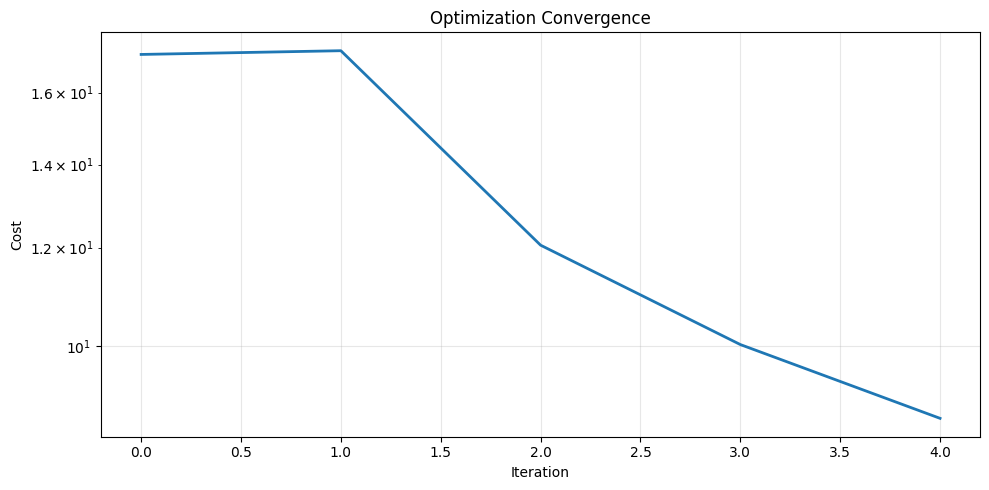

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(cost_history, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Optimization Convergence')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

## Compare optimized trajectory vs VICON

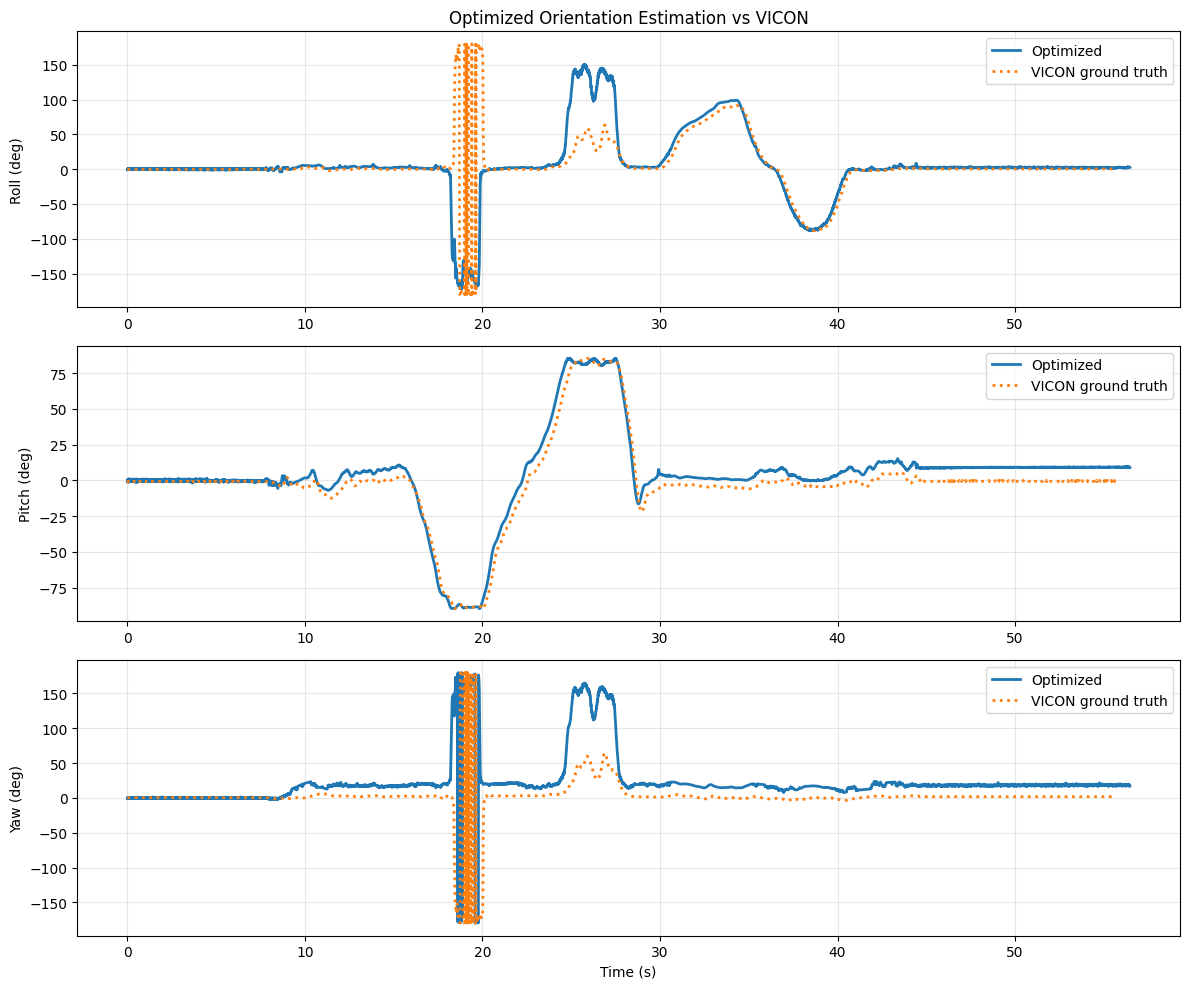

In [29]:
# Convert optimized quaternions to Euler angles
q_opt_np = q_optimized.cpu().numpy()
euler_opt = np.zeros((3, N))
for i in range(N):
    euler_opt[:, i] = quaternion_to_euler(q_opt_np[:, i])

# Plot: Initial integration vs Optimized vs VICON
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# axes[0].plot(imu_time, np.degrees(euler_est[0, :]), '--', label='Initial (IMU integration)', linewidth=1.5, alpha=0.7)
axes[0].plot(imu_time, np.degrees(euler_opt[0, :]), label='Optimized', linewidth=2)
axes[0].plot(vicon_time, np.degrees(euler_vicon[0, :]), ':', label='VICON ground truth', linewidth=2)
axes[0].set_ylabel('Roll (deg)')
axes[0].set_title('Optimized Orientation Estimation vs VICON')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# axes[1].plot(imu_time, np.degrees(euler_est[1, :]), '--', label='Initial (IMU integration)', linewidth=1.5, alpha=0.7)
axes[1].plot(imu_time, np.degrees(euler_opt[1, :]), label='Optimized', linewidth=2)
axes[1].plot(vicon_time, np.degrees(euler_vicon[1, :]), ':', label='VICON ground truth', linewidth=2)
axes[1].set_ylabel('Pitch (deg)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# axes[2].plot(imu_time, np.degrees(euler_est[2, :]), '--', label='Initial (IMU integration)', linewidth=1.5, alpha=0.7)
axes[2].plot(imu_time, np.degrees(euler_opt[2, :]), label='Optimized', linewidth=2)
axes[2].plot(vicon_time, np.degrees(euler_vicon[2, :]), ':', label='VICON ground truth', linewidth=2)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Yaw (deg)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part 2 — Panorama Construction (15 pts)

## Algorithm Overview

**Objective:** Construct a panoramic image by stitching RGB camera images over time using body orientation estimates $q_{1:T}$.

### Step 1: Sphere Projection
For each camera image:
- Assume the image is projected onto a unit sphere centered at the camera
- Compute world coordinates of each pixel using rows/columns, horizontal FOV, and vertical FOV
- Convert pixel coordinates $(u, v)$ to spherical coordinates: longitude $\lambda$ and latitude $\phi$

### Step 2: Camera to World Frame
- Express pixel positions in 3D Cartesian coordinates on unit sphere: $\mathbf{p} = (\cos\lambda \cos\phi, \sin\lambda \cos\phi, \sin\phi)$
- Rotate to world frame using camera-to-world rotation matrix $R$ (derived from $q_t$): $\mathbf{p}_{world} = R \mathbf{p}$

### Step 3: Cylindrical Projection & Unwrap
- Convert world Cartesian coordinates back to spherical: $(\lambda_{world}, \phi_{world})$
- Project onto cylinder: inscribe the sphere in a cylinder such that
  - Height on cylinder = $\phi_{world}$ (latitude)
  - Position around circumference = $\lambda_{world}$ (longitude)
- Unwrap cylinder to rectangular panorama image:
  - Width: $2\pi$ radians (full longitude)
  - Height: $\pi$ radians (full latitude from $-\pi/2$ to $\pi/2$)

### Implementation Notes
- Use closest-in-the-past timestamp of orientation estimates to align with each camera image
- Overwrite pixels when multiple images overlap (no color averaging required)
- Results acceptable even with noisy orientation estimates

In [30]:
# ============================================================================
# Panorama helper functions
# ============================================================================

def pixel_to_spherical(u, v, img_h, img_w, fov_h, fov_v):
    """Map pixel coordinates to spherical angles (lambda, phi).
    u, v can be scalars or arrays.
    lambda: longitude in [-fov_h/2, fov_h/2]
    phi: latitude in [-fov_v/2, fov_v/2] (positive up)
    """
    u_center = (img_w - 1) / 2.0
    v_center = (img_h - 1) / 2.0
    lambda_ang = (u - u_center) / (img_w - 1) * fov_h
    phi_ang = (v_center - v) / (img_h - 1) * fov_v
    return lambda_ang, phi_ang

def spherical_to_cartesian(lambda_ang, phi_ang):
    """Convert spherical (lambda, phi) to Cartesian on unit sphere."""
    cos_phi = np.cos(phi_ang)
    x = cos_phi * np.cos(lambda_ang)
    y = cos_phi * np.sin(lambda_ang)
    z = np.sin(phi_ang)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    """Convert Cartesian to spherical (lambda, phi)."""
    lambda_ang = np.arctan2(y, x)
    r_xy = np.sqrt(x**2 + y**2)
    phi_ang = np.arctan2(z, r_xy)
    return lambda_ang, phi_ang

def spherical_to_panorama_coords(lambda_ang, phi_ang, pano_w, pano_h):
    """Map spherical angles to panorama pixel coordinates."""
    pano_x = (lambda_ang + np.pi) / (2.0 * np.pi) * (pano_w - 1)
    pano_y = (np.pi / 2.0 - phi_ang) / np.pi * (pano_h - 1)
    return pano_x, pano_y

def find_closest_past_imu_idx(t_cam, imu_ts):
    """Return index of closest IMU timestamp <= camera time."""
    idx = np.searchsorted(imu_ts, t_cam, side="right") - 1
    return int(idx) if idx >= 0 else 0

In [31]:
# ============================================================================
# Create results directory
# ============================================================================
import os
from datetime import datetime

BASE_RESULTS_DIR = "../results"
run_stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RESULTS_DIR = os.path.join(BASE_RESULTS_DIR, f"run_{run_stamp}")
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_DIR}")

# ============================================================================
# Configuration
# ============================================================================
IMG_HEIGHT = 240
IMG_WIDTH = 320
FOV_H = np.radians(60)  # Horizontal FOV: 60 degrees 
FOV_V = np.radians(45)  # Vertical FOV: 45 degrees 

# Datasets: IMU/VICON have 1-9, Camera has only 1,2,8,9
TRAINING_DATASETS = list(range(1, 10))  # 1-9
# TRAINING_DATASETS = [1, 2, 8, 9]  # 1-9
CAMERA_DATASETS = [1, 2, 8, 9]

# Dictionary to store results for all datasets
ALL_RESULTS = {}

# ============================================================================
# Loop through all training datasets
# ============================================================================

for DATASET_ID in TRAINING_DATASETS:
    print("\n" + "="*80)
    print(f"PROCESSING DATASET {DATASET_ID}/9")
    print("="*80)
    
    dataset_str = str(DATASET_ID)
    
    # ========================================================================
    # PART 1: Load IMU/VICON and optimize trajectory
    # ========================================================================
    
    print("\n--- PART 1: IMU Orientation Optimization ---")
    ts = tic()
    
    # cfile = f"../data/trainset/cam/cam{dataset_str}.p" if DATASET_ID in CAMERA_DATASETS else None
    ifile = f"../data/trainset/imu/imuRaw{dataset_str}.p"
    vfile = f"../data/trainset/vicon/viconRot{dataset_str}.p"
    
    # Load IMU and VICON
    imud = read_data(ifile)
    vicd = read_data(vfile)
    
    # Extract IMU data
    imu_ts = imud[0, :]
    imu_vals = imud[1:7, :]
    
    # IMU calibration
    VREF_MV = 3300.0
    ACC_SENS_MV_PER_G = 330.0
    GYRO_SENS_MV_PER_RAD = 3.33 * 180.0 / np.pi
    ACC_SCALE = VREF_MV / 1023.0 / ACC_SENS_MV_PER_G
    GYRO_SCALE = VREF_MV / 1023.0 / GYRO_SENS_MV_PER_RAD
    
    imu_time = imu_ts - imu_ts[0]
    static_mask = imu_time < 2.0
    
    accel_raw = imu_vals[:3, :]
    gyro_raw = imu_vals[3:, :]
    
    accel_bias = accel_raw[:, static_mask].mean(axis=1) - np.array([0.0, 0.0, 1.0]) / ACC_SCALE
    gyro_bias = gyro_raw[:, static_mask].mean(axis=1) - np.array([0.0, 0.0, 0.0]) / GYRO_SCALE
    
    accel = (accel_raw - accel_bias[:, None]) * ACC_SCALE
    omega = (gyro_raw - gyro_bias[:, None]) * GYRO_SCALE
    
    # Extract VICON
    if isinstance(vicd, dict):
        vicon_rots = vicd["rots"]
        vicon_ts = vicd["ts"]
    else:
        raise ValueError(f"Unexpected VICON data format")
    
    vicon_ts = vicon_ts.flatten() if vicon_ts.ndim > 1 else vicon_ts
    
    N = imu_vals.shape[1]
    
    # Quaternion integration
    q_est = np.zeros((4, N))
    q_est[:, 0] = np.array([1.0, 0.0, 0.0, 0.0])
    
    for i in range(N - 1):
        tau = imu_ts[i + 1] - imu_ts[i]
        omega_t = omega[:, i]
        exp_quat = quaternion_exponential(tau * omega_t / 2.0)
        q_est[:, i + 1] = quaternion_multiply(q_est[:, i], exp_quat)
        q_est[:, i + 1] = normalize_quaternion(q_est[:, i + 1])
    
    # Convert to Euler
    euler_est = np.zeros((3, N))
    for i in range(N):
        euler_est[:, i] = quaternion_to_euler(q_est[:, i])
    
    # VICON to Euler
    N_vicon = vicon_rots.shape[2]
    euler_vicon = np.zeros((3, N_vicon))
    for i in range(N_vicon):
        euler_vicon[:, i] = t3d.euler.mat2euler(vicon_rots[:, :, i])
    
    vicon_time = vicon_ts - vicon_ts[0]
    
    # Optimization with PyTorch
    omega_torch = torch.from_numpy(omega).float().to(device)
    accel_torch = torch.from_numpy(accel).float().to(device)
    imu_ts_torch = torch.from_numpy(imu_ts).float().to(device)
    q_est_torch = torch.from_numpy(q_est).float().to(device)
    
    print("Running optimization...")
    q_optimized, cost_history = optimize_trajectory(
        q_est_torch,
        omega_torch,
        accel_torch,
        imu_ts_torch,
        learning_rate=0.01,
        num_iterations=100,
        verbose=True,
        adaptive_lr=True
    )
    
    q_opt_np = q_optimized.cpu().numpy()
    euler_opt = np.zeros((3, N))
    for i in range(N):
        euler_opt[:, i] = quaternion_to_euler(q_opt_np[:, i])
    
    toc(ts, f"Dataset {DATASET_ID} optimization")
    
    # ========================================================================
    # Save Part 1 plots and metrics
    # ========================================================================
    
    # Save optimized quaternion trajectory (PyTorch format)
    quat_file = os.path.join(RESULTS_DIR, f"dataset_{DATASET_ID}_q_optimized.pt")
    torch.save(q_optimized, quat_file)
    print(f"Saved quaternion trajectory: {quat_file}")
    
    # Plot 1: Optimized vs VICON
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # axes[0].plot(imu_time, np.degrees(euler_est[0, :]), '--', label='Initial (IMU)', linewidth=1.5, alpha=0.7)
    axes[0].plot(imu_time, np.degrees(euler_opt[0, :]), label='Optimized', linewidth=2)
    axes[0].plot(vicon_time, np.degrees(euler_vicon[0, :]), ':', label='VICON Ground Truth', linewidth=2)
    axes[0].set_ylabel('Roll (deg)')
    axes[0].set_title(f'Dataset {DATASET_ID}: Roll Estimation')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # axes[1].plot(imu_time, np.degrees(euler_est[1, :]), '--', label='Initial (IMU)', linewidth=1.5, alpha=0.7)
    axes[1].plot(imu_time, np.degrees(euler_opt[1, :]), label='Optimized', linewidth=2)
    axes[1].plot(vicon_time, np.degrees(euler_vicon[1, :]), ':', label='VICON Ground Truth', linewidth=2)
    axes[1].set_ylabel('Pitch (deg)')
    axes[1].set_title(f'Dataset {DATASET_ID}: Pitch Estimation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # axes[2].plot(imu_time, np.degrees(euler_est[2, :]), '--', label='Initial (IMU)', linewidth=1.5, alpha=0.7)
    axes[2].plot(imu_time, np.degrees(euler_opt[2, :]), label='Optimized', linewidth=2)
    axes[2].plot(vicon_time, np.degrees(euler_vicon[2, :]), ':', label='VICON Ground Truth', linewidth=2)
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Yaw (deg)')
    axes[2].set_title(f'Dataset {DATASET_ID}: Yaw Estimation')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_file = os.path.join(RESULTS_DIR, f"dataset_{DATASET_ID}_optimized_euler.png")
    plt.savefig(plot_file, dpi=100, bbox_inches='tight')
    plt.close()
    print(f"Saved: {plot_file}")
    
    # Plot 2: Convergence
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(cost_history, linewidth=2)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Cost')
    ax.set_title(f'Dataset {DATASET_ID}: Optimization Convergence')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    plt.tight_layout()
    plot_file = os.path.join(RESULTS_DIR, f"dataset_{DATASET_ID}_convergence.png")
    plt.savefig(plot_file, dpi=100, bbox_inches='tight')
    plt.close()
    print(f"Saved: {plot_file}")
    
    # Save metrics
    metrics = {
        'dataset_id': DATASET_ID,
        'n_imu_samples': N,
        'n_vicon_samples': N_vicon,
        'initial_cost': cost_history[0],
        'final_cost': cost_history[-1],
        'cost_reduction': cost_history[0] - cost_history[-1],
        'cost_reduction_pct': 100*(cost_history[0]-cost_history[-1])/cost_history[0],
        'n_iterations': len(cost_history)
    }
    
    ALL_RESULTS[DATASET_ID] = metrics
    
    print(f"✓ Dataset {DATASET_ID} Part 1 complete")
    print(f"  Initial cost: {metrics['initial_cost']:.6f}")
    print(f"  Final cost:   {metrics['final_cost']:.6f}")
    print(f"  Reduction:    {metrics['cost_reduction_pct']:.2f}%")
    
    # ========================================================================
    # PART 2: Panorama (only if camera data available)
    # ========================================================================
    
    if DATASET_ID in CAMERA_DATASETS:
        print(f"\n--- PART 2: Panorama Construction (Dataset {DATASET_ID}) ---")
        ts = tic()
        
        # Load camera
        cam_file = f"../data/trainset/cam/cam{dataset_str}.p"
        cam_data = read_data(cam_file)
        images_raw = cam_data['cam']
        cam_timestamps = cam_data['ts'].flatten()
        N_IMAGES = images_raw.shape[3]
        
        print(f"  Loaded {N_IMAGES} camera images")
        
        # Step 1: Pixel to spherical
        u_pixels = np.arange(IMG_WIDTH)
        v_pixels = np.arange(IMG_HEIGHT)
        u_grid, v_grid = np.meshgrid(u_pixels, v_pixels)
        
        lambda_grid, phi_grid = pixel_to_spherical(u_grid, v_grid, IMG_HEIGHT, IMG_WIDTH, FOV_H, FOV_V)
        
        x_cam, y_cam, z_cam = spherical_to_cartesian(lambda_grid, phi_grid)
        p_cam = np.stack([x_cam, y_cam, z_cam], axis=2)
        
        # Step 2: Rotate to world frame
        lambda_world_all = np.zeros((IMG_HEIGHT, IMG_WIDTH, N_IMAGES))
        phi_world_all = np.zeros((IMG_HEIGHT, IMG_WIDTH, N_IMAGES))
        
        for img_idx in range(N_IMAGES):
            cam_t = cam_timestamps[img_idx]
            imu_idx = find_closest_past_imu_idx(cam_t, imu_ts)
            q_t = q_opt_np[:, imu_idx]
            R = t3d.quaternions.quat2mat(q_t)
            
            p_cam_flat = p_cam.reshape(-1, 3)
            p_world_flat = (R @ p_cam_flat.T).T
            p_world = p_world_flat.reshape(IMG_HEIGHT, IMG_WIDTH, 3)
            
            x_world = p_world[:, :, 0]
            y_world = p_world[:, :, 1]
            z_world = p_world[:, :, 2]
            
            lambda_world, phi_world = cartesian_to_spherical(x_world, y_world, z_world)
            lambda_world_all[:, :, img_idx] = lambda_world
            phi_world_all[:, :, img_idx] = phi_world
        
        # Step 3: Stitch panorama
        PANO_RESOLUTION = 100
        PANO_WIDTH = int(2 * np.pi * PANO_RESOLUTION)
        PANO_HEIGHT = int(np.pi * PANO_RESOLUTION)
        panorama = np.zeros((PANO_HEIGHT, PANO_WIDTH, 3), dtype=np.uint8)
        
        for img_idx in range(N_IMAGES):
            lambda_w = lambda_world_all[:, :, img_idx]
            phi_w = phi_world_all[:, :, img_idx]
            img_data = images_raw[:, :, :, img_idx]
            
            pano_x, pano_y = spherical_to_panorama_coords(lambda_w, phi_w, PANO_WIDTH, PANO_HEIGHT)
            pano_x_int = np.round(pano_x).astype(int)
            pano_y_int = np.round(pano_y).astype(int)
            
            valid_mask = (
                (pano_x_int >= 0) & (pano_x_int < PANO_WIDTH) &
                (pano_y_int >= 0) & (pano_y_int < PANO_HEIGHT)
            )
            
            panorama[pano_y_int[valid_mask], pano_x_int[valid_mask], :] = img_data[valid_mask, :]
        
        # Calculate coverage
        coverage_mask = np.any(panorama > 0, axis=2)
        coverage_percentage = 100 * np.sum(coverage_mask) / (PANO_HEIGHT * PANO_WIDTH)
        
        toc(ts, f"Dataset {DATASET_ID} panorama")
        
        # Save panorama
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.imshow(panorama)
        # ax.set_title(f'Dataset {DATASET_ID}: Panoramic Image (Coverage: {coverage_percentage:.1f}%)')
        ax.set_xlabel('Longitude (pixels)')
        ax.set_ylabel('Latitude (pixels)')
        plt.tight_layout()
        plot_file = os.path.join(RESULTS_DIR, f"dataset_{DATASET_ID}_panorama.png")
        plt.savefig(plot_file, dpi=100, bbox_inches='tight')
        plt.close()
        print(f"Saved: {plot_file}")
        
        # Save panorama metrics
        metrics['panorama_coverage_pct'] = coverage_percentage
        metrics['panorama_height'] = PANO_HEIGHT
        metrics['panorama_width'] = PANO_WIDTH
        metrics['n_camera_images'] = N_IMAGES
        
        print(f"✓ Dataset {DATASET_ID} Part 2 complete")
        print(f"  Panorama coverage: {coverage_percentage:.1f}%")
    
    print(f"\n✓✓ Dataset {DATASET_ID} COMPLETE ✓✓\n")

# ============================================================================
# Save summary results
# ============================================================================

summary_file = os.path.join(RESULTS_DIR, "summary_results.txt")
with open(summary_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("ECE276A PANORAMA PROJECT - TRAINING RESULTS SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    for dataset_id in TRAINING_DATASETS:
        m = ALL_RESULTS[dataset_id]
        f.write(f"Dataset {dataset_id}:\n")
        f.write(f"  IMU samples: {m['n_imu_samples']}\n")
        f.write(f"  VICON samples: {m['n_vicon_samples']}\n")
        f.write(f"  Initial cost: {m['initial_cost']:.6f}\n")
        f.write(f"  Final cost: {m['final_cost']:.6f}\n")
        f.write(f"  Cost reduction: {m['cost_reduction_pct']:.2f}%\n")
        f.write(f"  Iterations: {m['n_iterations']}\n")
        if 'panorama_coverage_pct' in m:
            f.write(f"  Panorama coverage: {m['panorama_coverage_pct']:.1f}%\n")
        f.write("\n")

print(f"\n{'='*80}")
print(f"ALL TRAINING DATASETS PROCESSED")
print(f"Results saved to: {RESULTS_DIR}")
print(f"Summary: {summary_file}")
print(f"{'='*80}\n")

Results will be saved to: ../results/run_20260205_184140

PROCESSING DATASET 1/9

--- PART 1: IMU Orientation Optimization ---
Running optimization...
Iteration   0: Cost = 17.173277 (lr=1.00e-02)
Iteration  10: Cost = 2.456333 (lr=1.00e-02)
  lr decayed to 5.00e-03
Iteration  20: Cost = 1.613560 (lr=5.00e-03)
Iteration  30: Cost = 1.030532 (lr=5.00e-03)
Iteration  40: Cost = 0.691239 (lr=5.00e-03)
Iteration  50: Cost = 0.652633 (lr=5.00e-03)
Iteration  60: Cost = 0.636784 (lr=5.00e-03)
Iteration  70: Cost = 0.624266 (lr=5.00e-03)
Iteration  80: Cost = 0.622090 (lr=5.00e-03)
  lr decayed to 2.50e-03
Iteration  90: Cost = 0.621596 (lr=2.50e-03)
Cost stabilized (Δ=0.0794%), stopping at iteration 90
Dataset 1 optimization took: 0.4474070072174072 sec.

Saved quaternion trajectory: ../results/run_20260205_184140/dataset_1_q_optimized.pt
Saved: ../results/run_20260205_184140/dataset_1_optimized_euler.png
Saved: ../results/run_20260205_184140/dataset_1_convergence.png
✓ Dataset 1 Part 1 comp

In [32]:

# ============================================================================
# TESTSET PROCESSING (datasets 10, 11 - no VICON, only IMU and camera)
# ============================================================================

TESTSET_DATASETS = [10, 11]

for DATASET_ID in TESTSET_DATASETS:
    print("\n" + "="*80)
    print(f"PROCESSING TESTSET DATASET {DATASET_ID}")
    print("="*80)
    
    dataset_str = str(DATASET_ID)
    
    # ========================================================================
    # PART 1: Load IMU and optimize trajectory (no VICON)
    # ========================================================================
    
    print("\n--- PART 1: IMU Orientation Optimization (Testset) ---")
    ts = tic()
    
    ifile = f"../data/testset/imu/imuRaw{dataset_str}.p"
    
    # Load IMU only (no VICON for testset)
    imud = read_data(ifile)
    
    # Extract IMU data
    imu_ts = imud[0, :]
    imu_vals = imud[1:7, :]
    
    # IMU calibration
    VREF_MV = 3300.0
    ACC_SENS_MV_PER_G = 330.0
    GYRO_SENS_MV_PER_RAD = 3.33 * 180.0 / np.pi
    ACC_SCALE = VREF_MV / 1023.0 / ACC_SENS_MV_PER_G
    GYRO_SCALE = VREF_MV / 1023.0 / GYRO_SENS_MV_PER_RAD
    
    imu_time = imu_ts - imu_ts[0]
    static_mask = imu_time < 2.0
    
    accel_raw = imu_vals[:3, :]
    gyro_raw = imu_vals[3:, :]
    
    accel_bias = accel_raw[:, static_mask].mean(axis=1) - np.array([0.0, 0.0, 1.0]) / ACC_SCALE
    gyro_bias = gyro_raw[:, static_mask].mean(axis=1) - np.array([0.0, 0.0, 0.0]) / GYRO_SCALE
    
    accel = (accel_raw - accel_bias[:, None]) * ACC_SCALE
    omega = (gyro_raw - gyro_bias[:, None]) * GYRO_SCALE
    
    N = imu_vals.shape[1]
    
    # Quaternion integration
    q_est = np.zeros((4, N))
    q_est[:, 0] = np.array([1.0, 0.0, 0.0, 0.0])
    
    for i in range(N - 1):
        tau = imu_ts[i + 1] - imu_ts[i]
        omega_t = omega[:, i]
        exp_quat = quaternion_exponential(tau * omega_t / 2.0)
        q_est[:, i + 1] = quaternion_multiply(q_est[:, i], exp_quat)
        q_est[:, i + 1] = normalize_quaternion(q_est[:, i + 1])
    
    # Convert to Euler
    euler_est = np.zeros((3, N))
    for i in range(N):
        euler_est[:, i] = quaternion_to_euler(q_est[:, i])
    
    # Optimization with PyTorch
    omega_torch = torch.from_numpy(omega).float().to(device)
    accel_torch = torch.from_numpy(accel).float().to(device)
    imu_ts_torch = torch.from_numpy(imu_ts).float().to(device)
    q_est_torch = torch.from_numpy(q_est).float().to(device)
    
    print("Running optimization...")
    q_optimized, cost_history = optimize_trajectory(
        q_est_torch,
        omega_torch,
        accel_torch,
        imu_ts_torch,
        learning_rate=0.003,
        num_iterations=200,
        verbose=True,
        adaptive_lr=True
    )
    
    q_opt_np = q_optimized.cpu().numpy()
    euler_opt = np.zeros((3, N))
    for i in range(N):
        euler_opt[:, i] = quaternion_to_euler(q_opt_np[:, i])
    
    toc(ts, f"Testset Dataset {DATASET_ID} optimization")
    
    # ========================================================================
    # Save Part 1 plots and metrics
    # ========================================================================
    
    # Save optimized quaternion trajectory (PyTorch format)
    quat_file = os.path.join(RESULTS_DIR, f"dataset_{DATASET_ID}_q_optimized.pt")
    torch.save(q_optimized, quat_file)
    print(f"Saved quaternion trajectory: {quat_file}")
    
    # Plot 1: Optimized Euler angles (no VICON comparison for testset)
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    axes[0].plot(imu_time, np.degrees(euler_opt[0, :]), label='Optimized', linewidth=2)
    axes[0].set_ylabel('Roll (deg)')
    axes[0].set_title(f'Dataset {DATASET_ID}: Roll Estimation')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(imu_time, np.degrees(euler_opt[1, :]), label='Optimized', linewidth=2)
    axes[1].set_ylabel('Pitch (deg)')
    axes[1].set_title(f'Dataset {DATASET_ID}: Pitch Estimation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(imu_time, np.degrees(euler_opt[2, :]), label='Optimized', linewidth=2)
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Yaw (deg)')
    axes[2].set_title(f'Dataset {DATASET_ID}: Yaw Estimation')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plot_file = os.path.join(RESULTS_DIR, f"dataset_{DATASET_ID}_optimized_euler.png")
    plt.savefig(plot_file, dpi=100, bbox_inches='tight')
    plt.close()
    print(f"Saved: {plot_file}")
    
    # Plot 2: Convergence
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(cost_history, linewidth=2)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Cost')
    ax.set_title(f'Dataset {DATASET_ID}: Optimization Convergence')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    plt.tight_layout()
    plot_file = os.path.join(RESULTS_DIR, f"dataset_{DATASET_ID}_convergence.png")
    plt.savefig(plot_file, dpi=100, bbox_inches='tight')
    plt.close()
    print(f"Saved: {plot_file}")
    
    # Save metrics
    metrics = {
        'dataset_id': DATASET_ID,
        'n_imu_samples': N,
        'n_vicon_samples': 0,
        'initial_cost': cost_history[0],
        'final_cost': cost_history[-1],
        'cost_reduction': cost_history[0] - cost_history[-1],
        'cost_reduction_pct': 100*(cost_history[0]-cost_history[-1])/cost_history[0],
        'n_iterations': len(cost_history)
    }
    
    ALL_RESULTS[DATASET_ID] = metrics
    
    print(f"✓ Dataset {DATASET_ID} Part 1 complete")
    print(f"  Initial cost: {metrics['initial_cost']:.6f}")
    print(f"  Final cost:   {metrics['final_cost']:.6f}")
    print(f"  Reduction:    {metrics['cost_reduction_pct']:.2f}%")
    
    # ========================================================================
    # PART 2: Panorama (testset has camera data)
    # ========================================================================
    
    print(f"\n--- PART 2: Panorama Construction (Dataset {DATASET_ID}) ---")
    ts = tic()
    
    # Load camera
    cam_file = f"../data/testset/cam/cam{dataset_str}.p"
    cam_data = read_data(cam_file)
    images_raw = cam_data['cam']
    cam_timestamps = cam_data['ts'].flatten()
    N_IMAGES = images_raw.shape[3]
    
    print(f"  Loaded {N_IMAGES} camera images")
    
    # Step 1: Pixel to spherical
    u_pixels = np.arange(IMG_WIDTH)
    v_pixels = np.arange(IMG_HEIGHT)
    u_grid, v_grid = np.meshgrid(u_pixels, v_pixels)
    
    lambda_grid, phi_grid = pixel_to_spherical(u_grid, v_grid, IMG_HEIGHT, IMG_WIDTH, FOV_H, FOV_V)
    
    x_cam, y_cam, z_cam = spherical_to_cartesian(lambda_grid, phi_grid)
    p_cam = np.stack([x_cam, y_cam, z_cam], axis=2)
    
    # Step 2: Rotate to world frame
    lambda_world_all = np.zeros((IMG_HEIGHT, IMG_WIDTH, N_IMAGES))
    phi_world_all = np.zeros((IMG_HEIGHT, IMG_WIDTH, N_IMAGES))
    
    for img_idx in range(N_IMAGES):
        cam_t = cam_timestamps[img_idx]
        imu_idx = find_closest_past_imu_idx(cam_t, imu_ts)
        q_t = q_opt_np[:, imu_idx]
        R = t3d.quaternions.quat2mat(q_t)
        
        p_cam_flat = p_cam.reshape(-1, 3)
        p_world_flat = (R @ p_cam_flat.T).T
        p_world = p_world_flat.reshape(IMG_HEIGHT, IMG_WIDTH, 3)
        
        x_world = p_world[:, :, 0]
        y_world = p_world[:, :, 1]
        z_world = p_world[:, :, 2]
        
        lambda_world, phi_world = cartesian_to_spherical(x_world, y_world, z_world)
        lambda_world_all[:, :, img_idx] = lambda_world
        phi_world_all[:, :, img_idx] = phi_world
    
    # Step 3: Stitch panorama
    PANO_RESOLUTION = 100
    PANO_WIDTH = int(2 * np.pi * PANO_RESOLUTION)
    PANO_HEIGHT = int(np.pi * PANO_RESOLUTION)
    panorama = np.zeros((PANO_HEIGHT, PANO_WIDTH, 3), dtype=np.uint8)
    
    for img_idx in range(N_IMAGES):
        lambda_w = lambda_world_all[:, :, img_idx]
        phi_w = phi_world_all[:, :, img_idx]
        img_data = images_raw[:, :, :, img_idx]
        
        pano_x, pano_y = spherical_to_panorama_coords(lambda_w, phi_w, PANO_WIDTH, PANO_HEIGHT)
        pano_x_int = np.round(pano_x).astype(int)
        pano_y_int = np.round(pano_y).astype(int)
        
        valid_mask = (
            (pano_x_int >= 0) & (pano_x_int < PANO_WIDTH) &
            (pano_y_int >= 0) & (pano_y_int < PANO_HEIGHT)
        )
        
        panorama[pano_y_int[valid_mask], pano_x_int[valid_mask], :] = img_data[valid_mask, :]
    
    # Calculate coverage
    coverage_mask = np.any(panorama > 0, axis=2)
    coverage_percentage = 100 * np.sum(coverage_mask) / (PANO_HEIGHT * PANO_WIDTH)
    
    toc(ts, f"Dataset {DATASET_ID} panorama")
    
    # Save panorama
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(panorama)
    # ax.set_title(f'Dataset {DATASET_ID}: Panoramic Image (Coverage: {coverage_percentage:.1f}%)')
    ax.set_xlabel('Longitude (pixels)')
    ax.set_ylabel('Latitude (pixels)')
    plt.tight_layout()
    plot_file = os.path.join(RESULTS_DIR, f"dataset_{DATASET_ID}_panorama.png")
    plt.savefig(plot_file, dpi=100, bbox_inches='tight')
    plt.close()
    print(f"Saved: {plot_file}")
    
    # Save panorama metrics
    metrics['panorama_coverage_pct'] = coverage_percentage
    metrics['panorama_height'] = PANO_HEIGHT
    metrics['panorama_width'] = PANO_WIDTH
    metrics['n_camera_images'] = N_IMAGES
    
    print(f"✓ Dataset {DATASET_ID} Part 2 complete")
    print(f"  Panorama coverage: {coverage_percentage:.1f}%")
    
    print(f"\n✓✓ Dataset {DATASET_ID} COMPLETE ✓✓\n")

print(f"\n{'='*80}")
print(f"TESTSET PROCESSING COMPLETE")
print(f"Results saved to: {RESULTS_DIR}")
print(f"{'='*80}\n")



PROCESSING TESTSET DATASET 10

--- PART 1: IMU Orientation Optimization (Testset) ---
Running optimization...
Iteration   0: Cost = 5.054359 (lr=3.00e-03)
Iteration  10: Cost = 3.663640 (lr=3.00e-03)
Iteration  20: Cost = 2.748169 (lr=3.00e-03)
Iteration  30: Cost = 2.140999 (lr=3.00e-03)
Iteration  40: Cost = 1.759151 (lr=3.00e-03)
Iteration  50: Cost = 1.535131 (lr=3.00e-03)
Iteration  60: Cost = 1.411049 (lr=3.00e-03)
Iteration  70: Cost = 1.346040 (lr=3.00e-03)
Iteration  80: Cost = 1.313491 (lr=3.00e-03)
Iteration  90: Cost = 1.298192 (lr=3.00e-03)
Iteration 100: Cost = 1.291721 (lr=3.00e-03)
Iteration 110: Cost = 1.289451 (lr=3.00e-03)
  lr decayed to 1.50e-03
Cost stabilized (Δ=0.0912%), stopping at iteration 115
Testset Dataset 10 optimization took: 0.7668190002441406 sec.

Saved quaternion trajectory: ../results/run_20260205_184140/dataset_10_q_optimized.pt
Saved: ../results/run_20260205_184140/dataset_10_optimized_euler.png
Saved: ../results/run_20260205_184140/dataset_10_co

Loading results from: ../results/run_20260205_184140

--- Optimized Euler Angles (3x3) ---
Saved: ../results/run_20260205_184140/subplot_optimized_euler_3x3.png


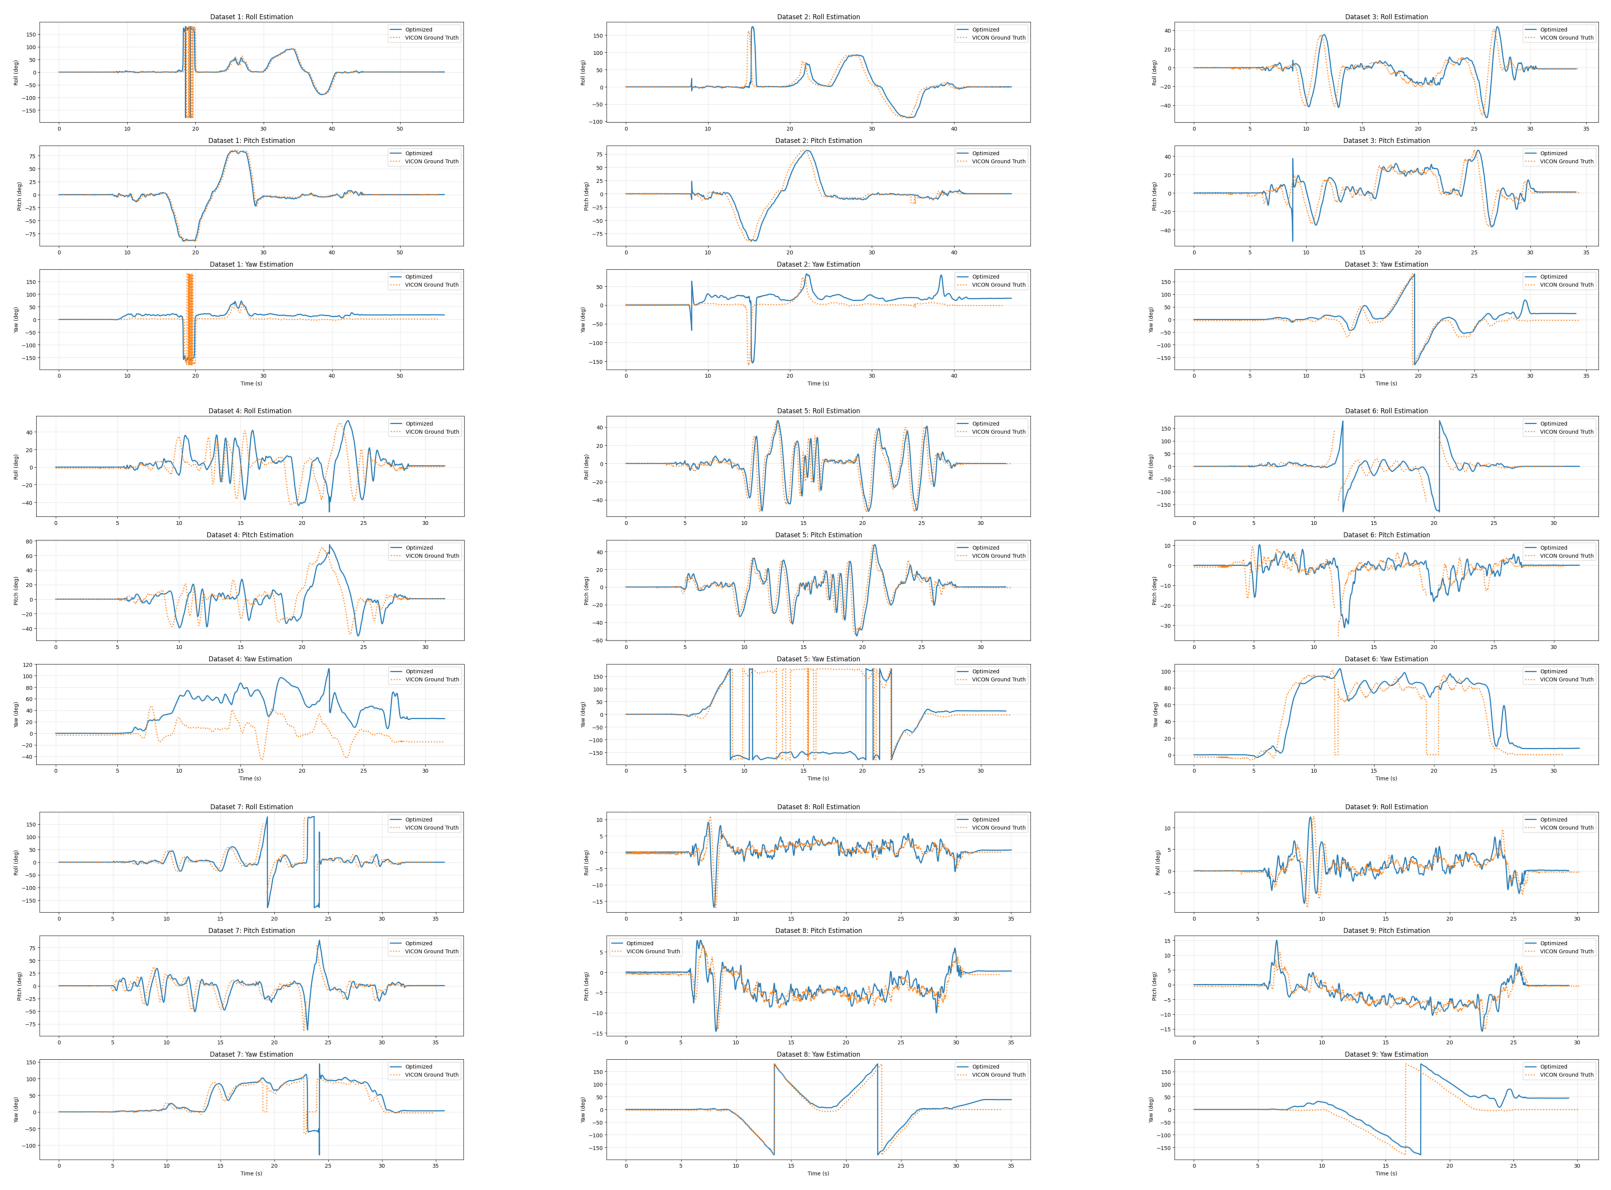


--- Convergence Curves (3x3) ---
Saved: ../results/run_20260205_184140/subplot_convergence_3x3.png


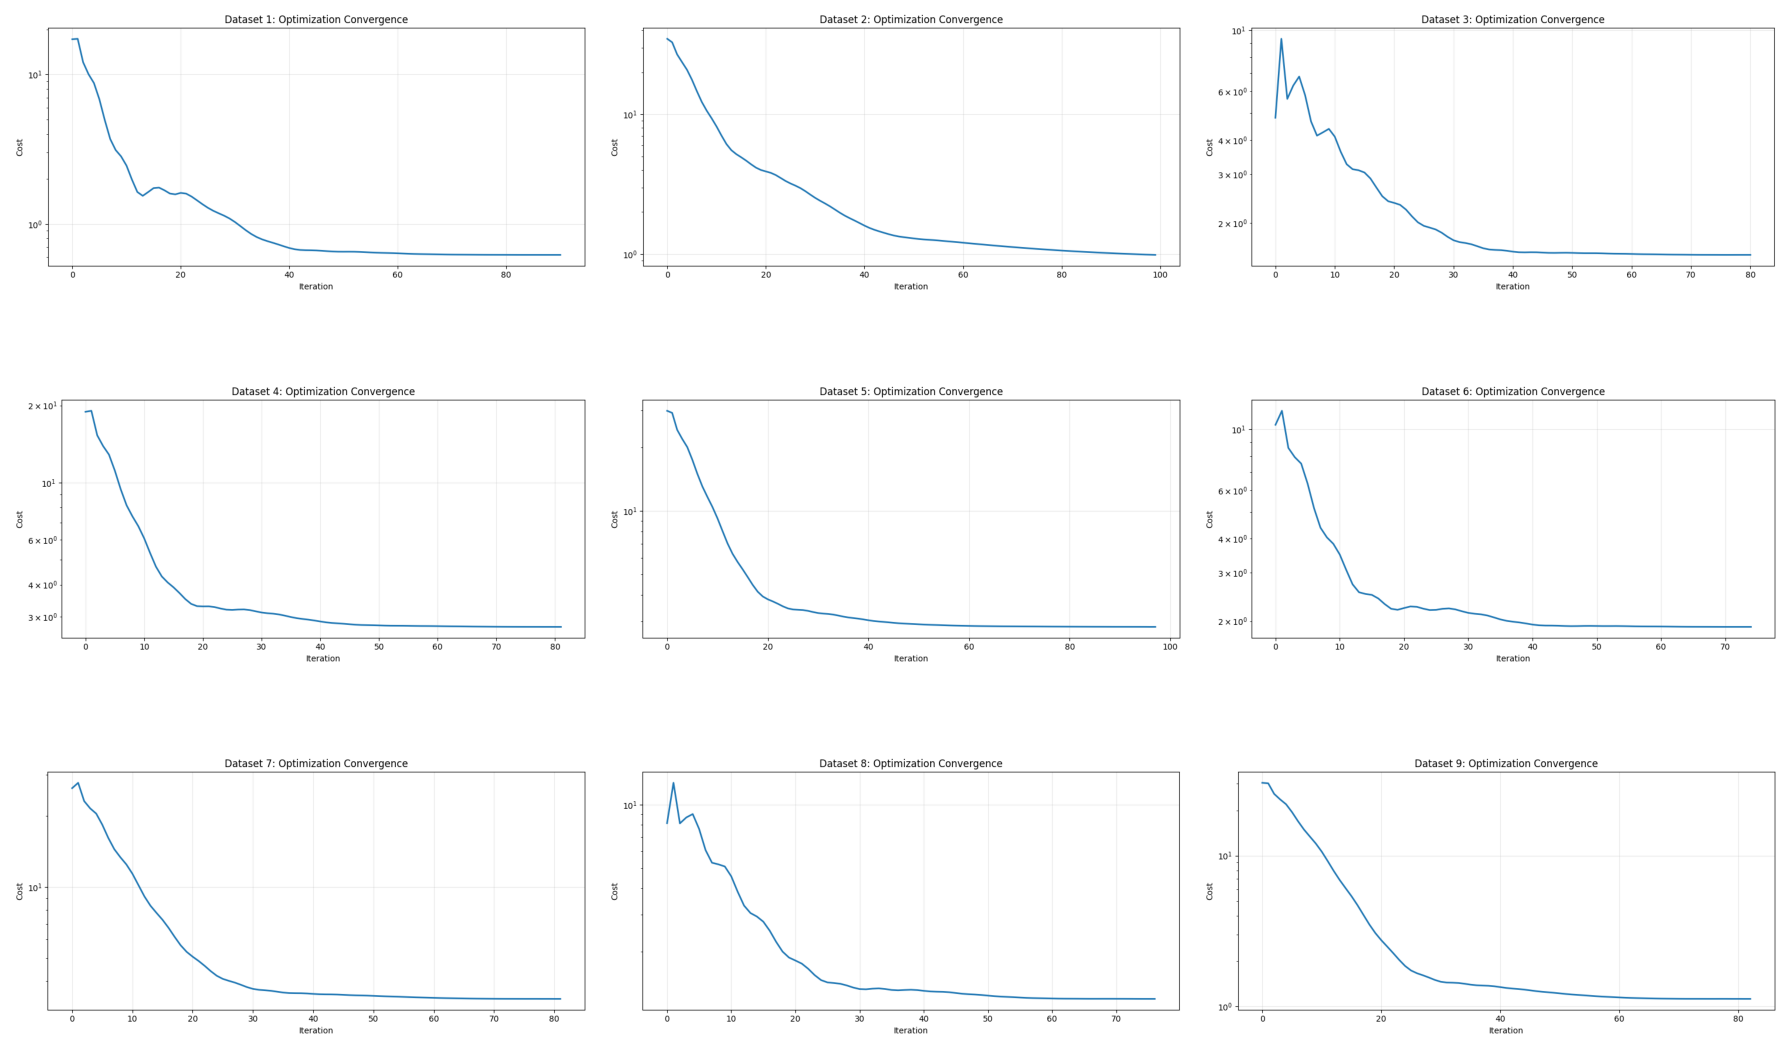


--- Camera Panoramas (2x2) ---
Saved: ../results/run_20260205_184140/subplot_panorama_2x2.png


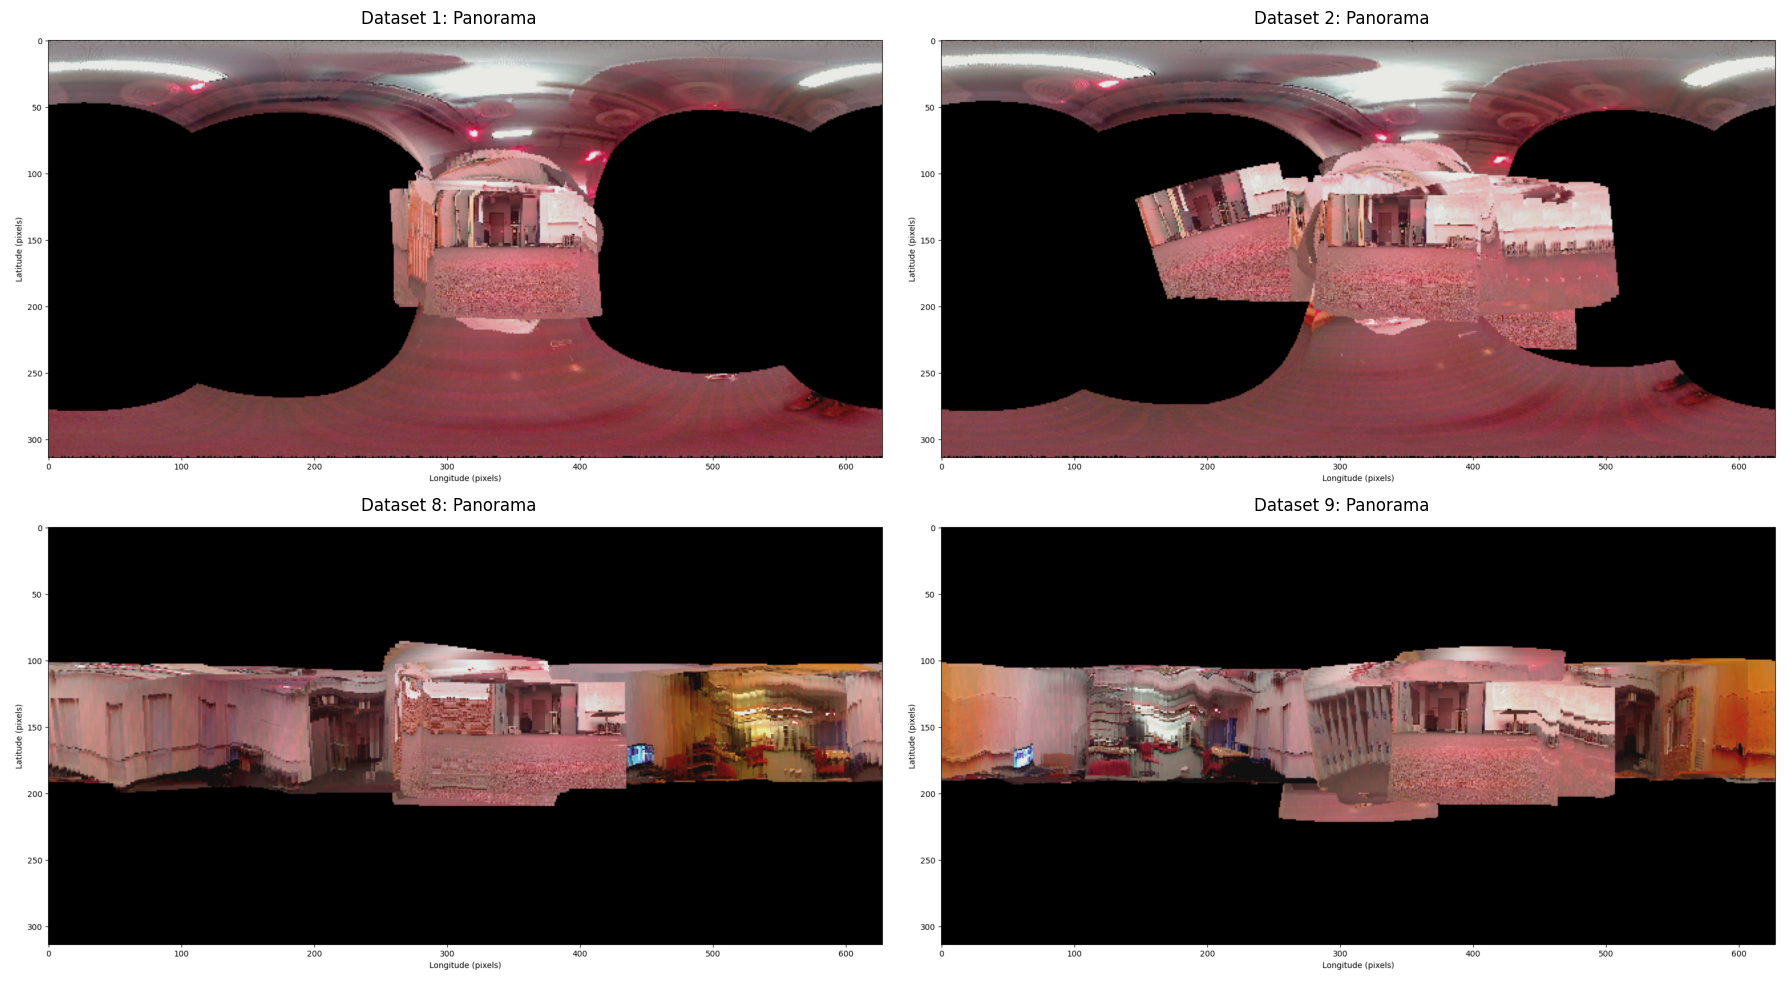


✓ All subplot figures saved to ../results/

TESTSET SUBPLOTS (1x2 format)
Created subfolder: ../results/run_20260205_184140/testset_subplots

--- Testset Optimized Euler Angles (1x2) ---
Saved: ../results/run_20260205_184140/testset_subplots/testset_optimized_euler_1x2.png


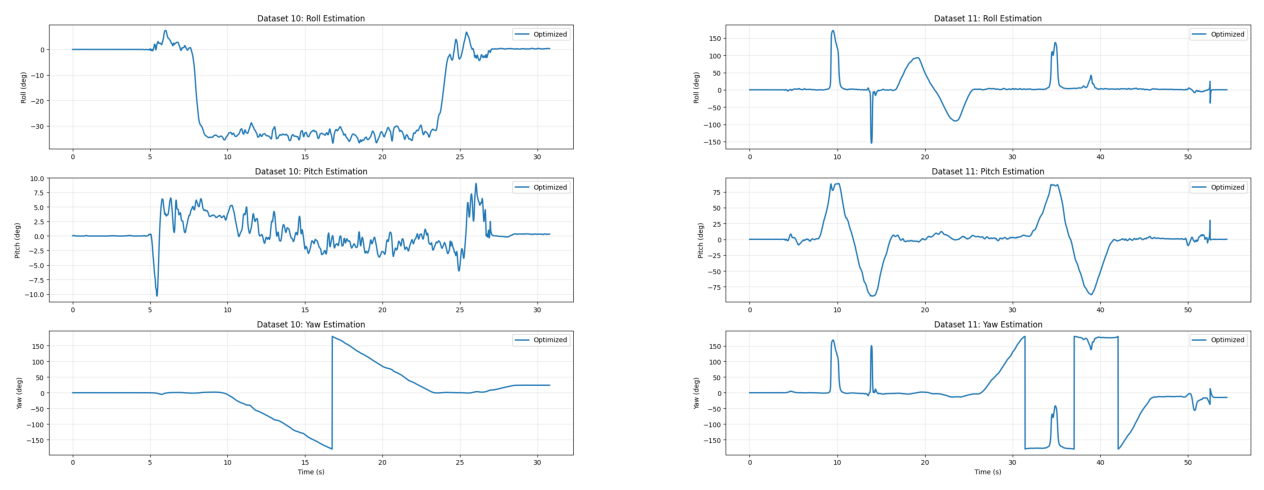


--- Testset Convergence Curves (1x2) ---
Saved: ../results/run_20260205_184140/testset_subplots/testset_convergence_1x2.png


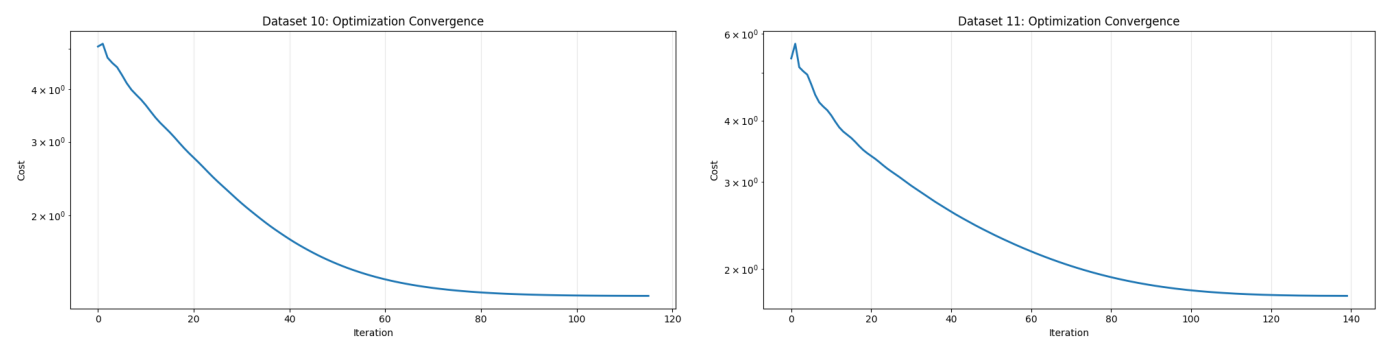


--- Testset Panoramas (1x2) ---
Saved: ../results/run_20260205_184140/testset_subplots/testset_panorama_1x2.png


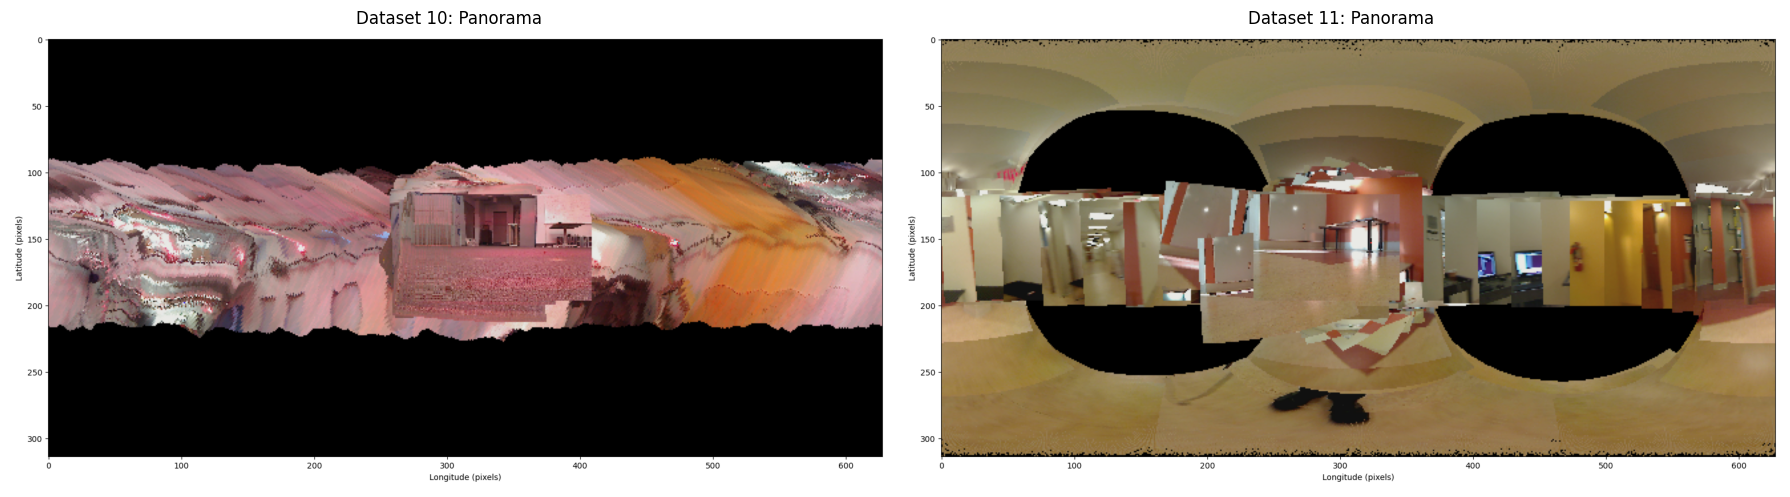


✓ All testset subplots saved to: ../results/run_20260205_184140/testset_subplots


In [34]:

# ============================================================================
# Load and visualize results from best run
# ============================================================================
import os
from PIL import Image

RESULTS_PATH = RESULTS_DIR

# Check if directory exists
if not os.path.exists(RESULTS_PATH):
    print(f"Results directory not found: {RESULTS_PATH}")
else:
    print(f"Loading results from: {RESULTS_PATH}")
    
    # ========== Plot 1: Optimized Euler Angles (3x3) for datasets with camera ==========
    print("\n--- Optimized Euler Angles (3x3) ---")
    camera_datasets = [1, 2, 8, 9]
    fig_euler, axes_euler = plt.subplots(3, 3, figsize=(18, 12))
    axes_euler = axes_euler.flatten()
    
    for idx, dataset_id in enumerate(range(1, 10)):
        plot_file = os.path.join(RESULTS_PATH, f"dataset_{dataset_id}_optimized_euler.png")
        if os.path.exists(plot_file):
            img = Image.open(plot_file)
            axes_euler[idx].imshow(img)
            # axes_euler[idx].set_title(f"Dataset {dataset_id}: Optimized Euler")
            axes_euler[idx].axis('off')
        else:
            axes_euler[idx].text(0.5, 0.5, f"Dataset {dataset_id}\n(no data)", 
                                ha='center', va='center', transform=axes_euler[idx].transAxes)
            axes_euler[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "subplot_optimized_euler_3x3.png"), dpi=100, bbox_inches='tight')
    print(f"Saved: {os.path.join(RESULTS_DIR, 'subplot_optimized_euler_3x3.png')}")
    plt.show()
    
    # ========== Plot 2: Convergence Curves (3x3) for all datasets ==========
    print("\n--- Convergence Curves (3x3) ---")
    fig_conv, axes_conv = plt.subplots(3, 3, figsize=(18, 12))
    axes_conv = axes_conv.flatten()
    
    for idx, dataset_id in enumerate(range(1, 10)):
        plot_file = os.path.join(RESULTS_PATH, f"dataset_{dataset_id}_convergence.png")
        if os.path.exists(plot_file):
            img = Image.open(plot_file)
            axes_conv[idx].imshow(img)
            axes_conv[idx].axis('off')
        else:
            axes_conv[idx].text(0.5, 0.5, f"Dataset {dataset_id}\n(no data)", 
                               ha='center', va='center', transform=axes_conv[idx].transAxes)
            axes_conv[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "subplot_convergence_3x3.png"), dpi=100, bbox_inches='tight')
    print(f"Saved: {os.path.join(RESULTS_DIR, 'subplot_convergence_3x3.png')}")
    plt.show()
    
    # ========== Plot 3: Camera Panoramas (2x2) ==========
    print("\n--- Camera Panoramas (2x2) ---")
    fig_pano, axes_pano = plt.subplots(2, 2, figsize=(18, 10))
    axes_pano = axes_pano.flatten()
    
    for idx, dataset_id in enumerate(camera_datasets):
        plot_file = os.path.join(RESULTS_PATH, f"dataset_{dataset_id}_panorama.png")
        if os.path.exists(plot_file):
            img = Image.open(plot_file)
            axes_pano[idx].imshow(img)
            axes_pano[idx].set_title(f"Dataset {dataset_id}: Panorama")
            axes_pano[idx].axis('off')
        else:
            axes_pano[idx].text(0.5, 0.5, f"Dataset {dataset_id}\n(no panorama)", 
                               ha='center', va='center', transform=axes_pano[idx].transAxes)
            axes_pano[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "subplot_panorama_2x2.png"), dpi=100, bbox_inches='tight')
    print(f"Saved: {os.path.join(RESULTS_DIR, 'subplot_panorama_2x2.png')}")
    plt.show()
    
    print("\n✓ All subplot figures saved to ../results/")
    
    # ========== Testset Subplots (1x2 format) ==========
    print("\n" + "="*80)
    print("TESTSET SUBPLOTS (1x2 format)")
    print("="*80)
    
    # Create testset subfolder
    testset_subplots_dir = os.path.join(RESULTS_DIR, "testset_subplots")
    os.makedirs(testset_subplots_dir, exist_ok=True)
    print(f"Created subfolder: {testset_subplots_dir}")
    
    testset_datasets = [10, 11]
    
    # ========== Testset Plot 1: Optimized Euler Angles (1x2) ==========
    print("\n--- Testset Optimized Euler Angles (1x2) ---")
    fig_euler_test, axes_euler_test = plt.subplots(1, 2, figsize=(14, 5))
    axes_euler_test = axes_euler_test.flatten()
    
    for idx, dataset_id in enumerate(testset_datasets):
        plot_file = os.path.join(RESULTS_PATH, f"dataset_{dataset_id}_optimized_euler.png")
        if os.path.exists(plot_file):
            img = Image.open(plot_file)
            axes_euler_test[idx].imshow(img)
            axes_euler_test[idx].axis('off')
        else:
            axes_euler_test[idx].text(0.5, 0.5, f"Dataset {dataset_id}\n(no data)", 
                                     ha='center', va='center', transform=axes_euler_test[idx].transAxes)
            axes_euler_test[idx].axis('off')
    
    plt.tight_layout()
    testset_euler_file = os.path.join(testset_subplots_dir, "testset_optimized_euler_1x2.png")
    plt.savefig(testset_euler_file, dpi=100, bbox_inches='tight')
    print(f"Saved: {testset_euler_file}")
    plt.show()
    
    # ========== Testset Plot 2: Convergence Curves (1x2) ==========
    print("\n--- Testset Convergence Curves (1x2) ---")
    fig_conv_test, axes_conv_test = plt.subplots(1, 2, figsize=(14, 5))
    axes_conv_test = axes_conv_test.flatten()
    
    for idx, dataset_id in enumerate(testset_datasets):
        plot_file = os.path.join(RESULTS_PATH, f"dataset_{dataset_id}_convergence.png")
        if os.path.exists(plot_file):
            img = Image.open(plot_file)
            axes_conv_test[idx].imshow(img)
            axes_conv_test[idx].axis('off')
        else:
            axes_conv_test[idx].text(0.5, 0.5, f"Dataset {dataset_id}\n(no data)", 
                                    ha='center', va='center', transform=axes_conv_test[idx].transAxes)
            axes_conv_test[idx].axis('off')
    
    plt.tight_layout()
    testset_conv_file = os.path.join(testset_subplots_dir, "testset_convergence_1x2.png")
    plt.savefig(testset_conv_file, dpi=100, bbox_inches='tight')
    print(f"Saved: {testset_conv_file}")
    plt.show()
    
    # ========== Testset Plot 3: Panoramas (1x2) ==========
    print("\n--- Testset Panoramas (1x2) ---")
    fig_pano_test, axes_pano_test = plt.subplots(1, 2, figsize=(18, 7))
    axes_pano_test = axes_pano_test.flatten()
    
    for idx, dataset_id in enumerate(testset_datasets):
        plot_file = os.path.join(RESULTS_PATH, f"dataset_{dataset_id}_panorama.png")
        if os.path.exists(plot_file):
            img = Image.open(plot_file)
            axes_pano_test[idx].imshow(img)
            axes_pano_test[idx].set_title(f"Dataset {dataset_id}: Panorama")
            axes_pano_test[idx].axis('off')
        else:
            axes_pano_test[idx].text(0.5, 0.5, f"Dataset {dataset_id}\n(no panorama)", 
                                    ha='center', va='center', transform=axes_pano_test[idx].transAxes)
            axes_pano_test[idx].axis('off')
    
    plt.tight_layout()
    testset_pano_file = os.path.join(testset_subplots_dir, "testset_panorama_1x2.png")
    plt.savefig(testset_pano_file, dpi=100, bbox_inches='tight')
    print(f"Saved: {testset_pano_file}")
    plt.show()
    
    print(f"\n✓ All testset subplots saved to: {testset_subplots_dir}")
